# Содержание
1. [Содержания работы](#Содержания-работы)
1. [Парсинг рук](#Парсинг-рук)
    1. [Инструментарий для работы с диапазонами](#Инструментарий-для-работы-с-диапазонами)
    2. [Инструментарий для остальных покерных преобразований и парсинга из нужного формата](#Инструментарий-для-остальных-покерных-преобразований-и-парсинга-из-нужного-формата)
    3. [Приведение десериализованных данных к удобному виду](#Приведение-десериализованных-данных-к-удобному-виду)
    4. [Парсинг многочисленых сессий в одну большую](#Парсинг-многочисленых-сессий-в-одну-большую)
2. [Предварительный анализ](#Предварительный-анализ)
    1. [Эффективный стек](#Эффективный-стек)
    2. [Разбиение по позициям](#Разбиение-по-позициям)
3. [Префлоп](#Префлоп)
    1. [Анализ первой гипотезы](#Анализ-первой-гипотезы)
        1. [Для начала посмотрим, какие руки вообще были у меня и у Дани](#Для-начала-посмотрим-какие-руки-вообще-были-у-меня-и-у-Дани)
        2. [Теперь посчитаем, сколько в среднем рука дает в бб](#Теперь-посчитаем-сколько-в-среднем-рука-дает-в-бб)
        3. [Сравненим с компьютерными теоретическими статистиками](#Сравненим-с-компьютерными-теоретическими-статистиками)
        4. [Визуализируем полученные матожидания](#Визуализируем-полученные-матожидания)
        5. [Результат анализа первой гипотезы](#Результат-анализа-первой-гипотезы)
    2. [Анализ второй гипотезы](#Анализ-второй-гипотезы)
        1. [Диапазоны открытия](#Диапазоны-открытия)
        2. [Парсинг солверного диапазона](#Парсинг-солверного-диапазона)
        3. [Посмотрим на частоты на маргинальных руках](#Посмотрим-на-частоты-на-маргинальных-руках)
        4. [Результат анализа второй гипотезы](#Результат-анализа-второй-гипотезы)
    3. [Остальные префлоп характеристики](#Остальные-префлоп-характеристики)
    4. [Диапазоны](#Диапазоны)
4. [Постфлоп](#Постфлоп)
    1. [Анализ первой гипотезы](#Анализ-первой-гипотезы-1)
        1. [Подготовка данных](#Подготовка-данных)
        2. [Анализ с помощью солвера](#Анализ-с-помощью-солвера)
        3. [Результат анализа первой гипотезы](#Результат-анализа-первой-гипотезы-1)
        4. [srp](#srp)
        5. [3bp](#3bp)
5. [Подведение итогов](#Подведение-итогов)
    2. [Заключение](#Заключение)


# Парсинг рук

#### Инструментарий для работы с диапазонами

In [175]:
import pandas as pd
import numpy as np

cards = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
suits = ['s', 'h', 'd', 'c']
class Range:
    @staticmethod 
    def get_template():
        d = {}
        for c in cards:
            d[c] = [0.0 for _ in range(13)]
            pass
        return pd.DataFrame.from_dict(d, orient='index', columns=cards)
        

    def __init__(self, range_matrix=[], range_dict={}):
        self.df = Range.get_template()
        if len(range_matrix) == 0:
            self.matrix = [[0 for _ in range(13)] for _ in range(13)]
            assert len(self.matrix) == 13
            for i in range(13):
                assert len(self.matrix[i]) == 13
        else:
            assert len(range_matrix) == 13
            for i in range(13):
                assert len(range_matrix[i]) == 13
            self.matrix = range_matrix
        if range_dict != {}:
            assert len(range_dict.keys()) == 52*51 // 2
            self.d = range_dict
        else:
            self.d = {}
            for c1 in cards:
                for s1 in suits:
                    for c2 in cards:
                        for s2 in suits:
                            t1 = c1 + s1
                            t2 = c2 + s2
                            # print("c1, c2:", t1, t2)
                            if t1 != t2:
                                combo = Range.get_combo(t1, t2)
                                # print(combo)
                                self.d[combo] = 0
            # print(*list(self.d.keys()))
            assert len(self.d.keys()) == 52*51 // 2

        for i, card1 in enumerate(cards):
            for j, card2 in enumerate(cards):
                self.df[card1].iloc[j] = self.matrix[i][j]

    @staticmethod
    def sort(c1, c2):
        # sort
        i1, i2 = cards.index(c1), cards.index(c2)
        i1, i2 = sorted([i1, i2])
        c1, c2 = cards[i1], cards[i2]
        return c1, c2


    @staticmethod
    def get_combo(c1, c2):
        s1, s2 = c1[1], c2[1]
        c1, c2 = c1[0], c2[0]

        i1, i2 = cards.index(c1), cards.index(c2)
        if i1 < i2:
            return c1+s1+c2+s2
        elif i1 == i2:
            i1, i2 = suits.index(s1), suits.index(s2)
            if i1 < i2:
                return c1+s1+c2+s2
            return c2+s2+c1+s1 
        else:
            return c2+s2+c1+s1 
        
    def set(self, combo, frequency):
        c1, c2 = combo[0], combo[2]
        c1, c2 = self.sort(c1, c2)

        s1, s2 = combo[1], combo[3]
        if s1 == s2:
            # suited
            self.df.loc[c1].iloc[cards.index(c2)] = frequency
        else:
            #offsuit
            self.df.loc[c2].iloc[cards.index(c1)] = frequency
        
        self.d[combo] = frequency

    def get(self, combo):
        if len(combo) < 4:
            print(combo)
        c1, c2 = combo[0], combo[2]
        # sort
        c1, c2 = self.sort(c1, c2)

        return self.d[combo]

    def display(self):
        print(self.df)

    def __str__(self):
        s = ""
        for k, v in self.d.items():
            if v == 0:
                continue
            s += k
            if v != 1.0:
                s += ':'
                s += str(v)
            s += ','
        return s

#### Инструментарий для остальных покерных преобразований и парсинга из нужного формата

In [176]:
import json

class Game:
	def __init__(self, file):
		text = file.read()
		self.info = json.loads(text)
		self.hands = parse_hands(self.info["hands"])

from enum import Enum
class EventType(Enum):
	x = 0
	bb = 2
	sb = 3
	c = 7
	r = 8
	new_card = 9
	hand_over = 10
	f = 11
	shows = 12,
	takes_pot = 15
	wins = 16

class Act(Enum):
	f = 0
	x = 1
	c = 2
	r = 3

class PreflopActionType(Enum):
	srp = 0
	_3bet = 1
	_4bet = 2
	_5bet = 3
	_6bet = 4

class Event:
	events = {
				0: "check", 
				1: "1", 
				2: "big blind",
				3: "small blind",			
				4: "4",			
				5: "5",			
				6: "6",			
				7: "call",
				8: "raise",
				9: "card comes",
				10: "hand is over",
				11: "fold",
				12: "shows",
				13: "13",
				14: "14",
				15: "takes money",
				16: "win"
			}
	def __init__(self, event, players):
		self.type = event["type"]
		self.value = event.get("value")
		self.seat = event.get("seat")
		self.runout = event.get("cards")
		self.players = {}
		for player in players:
			self.players[player["seat"]] = player["name"]

	def __str__(self):
		result = ""
		if self.seat:
			result += self.players[self.seat] + " "
		result += self.type + " "
		if self.value:
			result += str(self.value)
		result += "\n"
		return result	

class Player:
	def __init__(self, d):
		self.d = d
		self.id = d['id']
		self.name = d['name']
		self.stack = d['stack']
		self.holding = d.get('hand', None)

from datetime import datetime
class Hand:
	def __init__(self, d):
		self.d = d
		self.id = d["id"]
		self.timestamp = d['startedAt']
		self.dt = datetime.fromtimestamp(self.timestamp // 1e3)
		self.number = int(d["number"])
		self._bb_value = d["bigBlind"]
		self.players = [Player(p) for p in d["players"]]
		self.action = Action(d["events"], d['players'], self._bb_value)
		self.action.potsize /= self._bb_value
		self.effective_stack = self.players[0].stack
		for p in self.players:
			if p.stack < self.effective_stack:
				self.effective_stack = p.stack
		
		self.effective_stack /= self._bb_value
		btn_seat = d['dealerSeat']
		for p in d['players']:
			if btn_seat == p['seat']:
				self.btn = p['name']

		if "hand" in d['players'][0] and "hand" in d['players'][1]:
			self.showdown = True
		else:
			self.showdown = False

	def __str__(self):
		return f"id: {self.id}\nnumber: {self.number}\n"


	def display_action(self):
		print(self.action)
		if self.showdown:
			print()
			print(self.players[0]["name"], self.players[0]["hand"])
			print(self.players[1]["name"], self.players[1]["hand"])

class Action:
	def __init__(self, events, players, bb_size):
		self.events = []
		for e in events:
			self.events.append(Event(e["payload"], players))
		self.line = ""
		self.winner = "-"
		self.prefloptype_s = "-"
		stage = 0

		self.extended_line = ""
		# runout
		self.runout = []
		self.flop = ""
		self.turn = ""
		self.river = ""

		for e in self.events:
			if e.type == EventType.x.value:
				self.line += 'x'
				self.extended_line += "x"
			if e.type == EventType.c.value:
				self.line += 'c'
				self.extended_line += 'c'
			if e.type == EventType.r.value:
				if len(self.line) != 0 and (self.line[-1] == 'b' or self.line[-1] == 'r'):
					self.line += 'r'
					self.extended_line += 'r'
					self.extended_line += str(e.value / bb_size)
				else:
					self.line += 'b'
					self.extended_line += 'b'
					self.extended_line += str(e.value / bb_size)
			if e.type == EventType.f.value:
				self.line += 'f'
				self.extended_line += 'f'
			
			if e.type == EventType.new_card.value:
				self.line += '-'
				self.extended_line += '-'
				if stage == 0:
					self.flop = "".join(e.runout)
				elif stage == 1:
					self.turn = "".join(e.runout)
				elif stage == 2:
					self.river = "".join(e.runout)
				stage += 1

			if e.type == EventType.hand_over.value:
				self.winner = e.players.get(e.seat)
			# if e.type == EventType.takes_pot.value:
				self.potsize = e.value
		preflop = self.line.split('-')[0]
		if preflop == 'bc' or preflop == 'bf':
			self.prefloptype_s = 'srp'
		elif preflop == 'brc' or preflop == 'brf':
			self.prefloptype_s = '3bp'
		elif preflop == 'brrc' or preflop == 'brrf':
			self.prefloptype_s = '4bp'
		elif preflop == 'brrrc' or preflop == 'brrrf':
			self.prefloptype_s = '5bp'
		# print(self.line)
		# self.flop, self.turn, self.river = 
		if self.flop:
			self.runout.append(self.flop)
		if self.turn:
			self.runout.append(self.turn)
		if self.river:
			self.runout.append(self.river)
	
	def __str__(self):
		result = ""
		for e in self.events:
			result += str(e)
		return result

def parse_hands(hands_json):
	hands = []
	for hand in hands_json:
		hands.append(Hand(hand))
	return hands



#### Приведение десериализованных данных к удобному виду

In [177]:
def dataframe(hands, aliases={}):
    times = []
    lines = []
    winners = []
    preflops = []
    potsizes = []
    effectives = []
    dealer = []
    hero_hands = []
    zond_hands = []

    runouts = []
    extended_lines = []

    for i in range(len(hands)):
        def f(name):
            return aliases.get(name, name)
        h = hands[i]
        times.append(h.dt)
        lines.append(h.action.line)
        winners.append(f(h.action.winner))
        preflops.append(h.action.prefloptype_s)
        potsizes.append(h.action.potsize)
        effectives.append(h.effective_stack)
        dealer.append(f(h.btn))

        if len(h.action.runout):
            runouts.append("-".join(h.action.runout))
        else:
            runouts.append("-")
        extended_lines.append(h.action.extended_line)

        for p in h.players:
            if f(p.name) == 'hero':
                if p.holding == None:
                    hero_hands.append("-")
                    continue
                c1, c2 = p.holding
                hero_hands.append(Range.get_combo(c1, c2))
            if f(p.name) == 'zondberg':
                if p.holding == None:
                    zond_hands.append("-")
                    continue
                    
                c1, c2 = p.holding
                zond_hands.append(Range.get_combo(c1, c2))

    df = pd.DataFrame({'Time': times, 
                       'Preflop': preflops, 
                       'Line': lines, 
                       'Winner': winners, 
                       'Pot (bb)': potsizes, 
                       'Effective stack (bb)': effectives,
                       'Dealer': dealer,
                       'Hero hand': hero_hands,
                       'Opponent hand': zond_hands,
                       'Extended line': extended_lines,
                       'Runout': runouts})
    return df

#### Парсинг многочисленых сессий в одну большую

In [178]:
me   = ['bonker', 'кефтэмэ', 'cloexec', 'FLOCKA', 'over bop']
zond = ['shadow value', 'flexorcist', 'tantric edging', 'bot2000', 'ебурчик', 'squoznyak', 'dont gas me']
aliases = {}

for name in me:
    aliases[name] = 'hero'
for name in zond:
    aliases[name] = 'zondberg'

def combine_cards(hands1, hands2, aliases={}):
    '''
    returns combined showdown hands
    hands1 has hero cards
    '''
    assert len(hands1) == len(hands2)

    def f(name):
        return aliases.get(name, name)

    # zond_i = 0
    # for i, p in enumerate(hands1[0].players):
    #     if f(p.name) == 'hero':
    #         zond_i = 1 - i

    for i in range(len(hands1)):
        zond_i = 0
        if hands1[i].players[0].holding:
            zond_i = 1
        hands1[i].players[zond_i].holding = hands2[i].players[zond_i].holding
    return hands1

sessions = [
            "21_03_24",
            "22_03_24",
            "23_03_24",
            "24_03_24_second", 
            "27_03_24",
            "25_04_24_1",
            "25_04_24_2"
            ]
frames = []
for session in sessions:
    def to_path(session):
        return "data/" + session + ".json"

    filename1 = to_path(session)
    filename2 = to_path(session + "_zond")

    file1 = open(filename1, 'r')
    file2 = open(filename2, 'r')
    game1 = Game(file1)
    game2 = Game(file2)

    all_hands1 = game1.hands
    all_hands2 = game2.hands

    all_hands = combine_cards(all_hands1, all_hands2)
    df = dataframe(all_hands, aliases)
    print(len(df))
    frames.append(df)
df = pd.concat(frames)

200
241


296
680
465
601
603


In [179]:
print(len(df))
df.iloc[7].loc['Runout']

3086


'AcTc3d-Kh-2s'

# Предварительный анализ

### Эффективный стек

3086


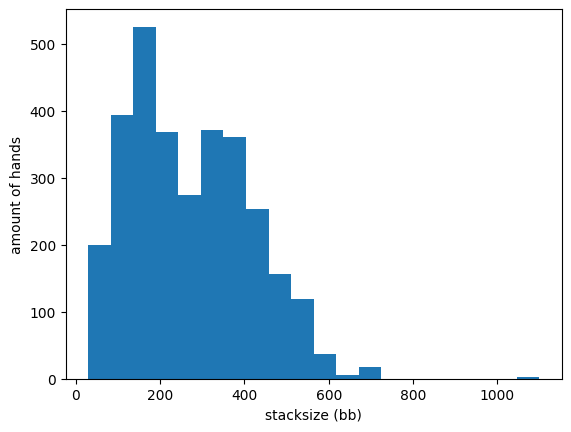

In [180]:
from matplotlib import pyplot as plt

plt.hist(df['Effective stack (bb)'], bins=20)
print(len(df))
plt.xlabel('stacksize (bb)')
plt.ylabel('amount of hands')
plt.show()

Для большей унификации ситуаций, отсечем руки, где эффективный стек был меньше 100бб

2840


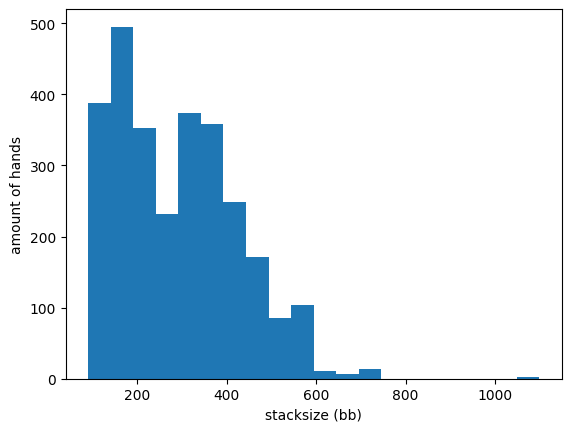

In [181]:
# df = df[df['Effective stack (bb)'] <= 600]
df = df[df['Effective stack (bb)'] > 90]
print(len(df))
plt.hist(df['Effective stack (bb)'], bins=20)
plt.xlabel('stacksize (bb)')
plt.ylabel('amount of hands')
plt.show()

In [182]:
df = df[df['Hero hand'] != '-']
df = df[df['Opponent hand'] != '-']
print(len(df))

2821


### Разбиение по позициям 
Для унификации покерных ситуаций, разобьем полученные данные на две группы - где на диллере я, и где Даня.
Так все ситуации будут идентичны, с точностью до эффективного стека и рук.

In [183]:
ip = df[df['Dealer'] == 'hero']
oop = df[df['Dealer'] == 'zondberg']

In [184]:
ip.head(10)

,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout
1,2024-03-22 01:03:59,-,f,zondberg,1.0,99.5,hero,6h3s,JdTs,f,-
3,2024-03-22 01:04:15,-,f,zondberg,1.0,99.0,hero,9s4d,Tc5h,f,-
5,2024-03-22 01:04:33,srp,bf,hero,2.0,99.0,hero,Ad7h,8h4c,b2.5f,-
7,2024-03-22 01:04:47,srp,bc-xx-xbc-xx,zondberg,10.0,99.0,hero,JhJd,Ad9h,b2.5c-xx-xb2.5c-xx,AcTc3d-Kh-2s
9,2024-03-22 01:05:23,3bp,brc-xbf,hero,21.0,95.0,hero,8s6s,9c7c,b2.5r10.5c-xb7.0f,2d8d4d
11,2024-03-22 01:06:01,3bp,brc-xx-xx-xbf,hero,19.0,92.0,hero,KhTc,Ac8c,b2.5r9.5c-xx-xx-xb19.0f,KdJs3d-Jd-Qc
17,2024-03-22 01:08:37,srp,bf,hero,2.0,96.0,hero,AcTc,5h2s,b2.5f,-
19,2024-03-22 01:08:49,-,f,zondberg,1.0,94.5,hero,6d2s,7s3h,f,-
21,2024-03-22 01:09:01,-,f,zondberg,1.0,96.0,hero,Tc7d,Qd5h,f,-
23,2024-03-22 01:09:27,srp,bf,hero,2.0,97.5,hero,Jc5c,7c4h,b2.5f,-


# Префлоп

**Гипотеза первая**: Пограничные руки, которые имеют около нулевое математическое ожидание для солвера, для нас с Даней для обоих имеют отрицательное матожидание из-за сложности игры с ними.

**Гипотеза вторая**: Пограничные руки из диапазона открытия мы оба с Даней открывать будем сильно реже, чем в оптимальной стратегии, потому что эти диапазоны мы выработали на основе собственных ощущений, а пограничные руки гораздо сложнее играть и из-за этого кажется, что ты с ними больше проигрываешь, чем выигрываешь.

### Анализ первой гипотезы

#### Для начала посмотрим, какие руки вообще были у меня и у Дани

In [185]:
my_hands_ip = Range.get_template()
zond_hands_ip = Range.get_template()

my_hands_oop = Range.get_template()
zond_hands_oop = Range.get_template()

for row in ip.iterrows():
    #my
    combo = row[1]['Hero hand']
    c1, c2 = combo[0], combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = combo[1], combo[3]
    if s1 == s2:
        # suited
        my_hands_ip.loc[c1].iloc[cards.index(c2)] += 1
    else:
        #offsuit
        my_hands_ip.loc[c2].iloc[cards.index(c1)] += 1
    
    # zond
    combo = row[1]['Opponent hand']
    c1, c2 = combo[0], combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = combo[1], combo[3]
    if s1 == s2:
        # suited
        zond_hands_oop.loc[c1].iloc[cards.index(c2)] += 1
    else:
        #offsuit
        zond_hands_oop.loc[c2].iloc[cards.index(c1)] += 1

for row in oop.iterrows():
    #my
    combo = row[1]['Hero hand']
    c1, c2 = combo[0], combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = combo[1], combo[3]
    if s1 == s2:
        # suited
        my_hands_oop.loc[c1].iloc[cards.index(c2)] += 1
    else:
        #offsuit
        my_hands_oop.loc[c2].iloc[cards.index(c1)] += 1
    
    # zond
    combo = row[1]['Opponent hand']
    c1, c2 = combo[0], combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = combo[1], combo[3]
    if s1 == s2:
        # suited
        zond_hands_ip.loc[c1].iloc[cards.index(c2)] += 1
    else:
        #offsuit
        zond_hands_ip.loc[c2].iloc[cards.index(c1)] += 1

In [186]:
my_hands_ip

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,6.0,1.0,3.0,6.0,8.0,2.0,5.0,6.0,6.0,10.0,2.0,6.0,2.0
K,19.0,4.0,8.0,3.0,5.0,2.0,4.0,1.0,6.0,3.0,0.0,2.0,3.0
Q,12.0,11.0,7.0,1.0,7.0,8.0,2.0,6.0,6.0,7.0,3.0,3.0,3.0
J,10.0,20.0,11.0,5.0,3.0,5.0,2.0,2.0,4.0,1.0,3.0,7.0,9.0
T,12.0,18.0,14.0,8.0,8.0,6.0,7.0,4.0,10.0,4.0,1.0,5.0,3.0
9,16.0,16.0,16.0,7.0,11.0,3.0,3.0,7.0,7.0,6.0,2.0,4.0,5.0
8,11.0,23.0,18.0,18.0,23.0,13.0,3.0,8.0,6.0,3.0,5.0,4.0,3.0
7,15.0,12.0,15.0,11.0,12.0,12.0,7.0,8.0,2.0,3.0,4.0,3.0,3.0
6,7.0,13.0,10.0,12.0,9.0,12.0,13.0,10.0,10.0,3.0,4.0,6.0,5.0
5,14.0,11.0,14.0,13.0,17.0,11.0,15.0,12.0,8.0,5.0,4.0,4.0,3.0


In [187]:
my_hands_oop

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,8.0,1.0,4.0,5.0,4.0,4.0,3.0,6.0,8.0,5.0,1.0,2.0,1.0
K,11.0,5.0,7.0,3.0,6.0,5.0,3.0,4.0,5.0,7.0,8.0,6.0,2.0
Q,13.0,11.0,4.0,0.0,7.0,4.0,6.0,4.0,7.0,4.0,3.0,3.0,3.0
J,15.0,10.0,16.0,5.0,5.0,5.0,8.0,4.0,4.0,4.0,8.0,1.0,3.0
T,16.0,9.0,9.0,15.0,4.0,3.0,4.0,1.0,4.0,2.0,5.0,4.0,7.0
9,19.0,10.0,9.0,12.0,12.0,6.0,1.0,3.0,6.0,5.0,2.0,2.0,8.0
8,15.0,8.0,11.0,14.0,15.0,18.0,4.0,5.0,6.0,8.0,5.0,3.0,4.0
7,13.0,19.0,10.0,13.0,15.0,15.0,16.0,7.0,4.0,3.0,3.0,6.0,2.0
6,16.0,17.0,10.0,13.0,12.0,15.0,14.0,15.0,3.0,3.0,8.0,4.0,6.0
5,17.0,9.0,8.0,13.0,12.0,10.0,15.0,14.0,11.0,3.0,5.0,4.0,4.0


#### Теперь посчитаем, сколько в среднем рука дает в бб

In [188]:
d = {}
for c in cards:
    d[c] = [0.0 for _ in range(13)]

my_hands_ip_ev = pd.DataFrame.from_dict(d, orient='index', columns=cards)
zond_hands_ip_ev = pd.DataFrame.from_dict(d, orient='index', columns=cards)

my_hands_oop_ev = pd.DataFrame.from_dict(d, orient='index', columns=cards)
zond_hands_oop_ev = pd.DataFrame.from_dict(d, orient='index', columns=cards)

for i, row in ip.iterrows():
    # print(row)
    hero_combo = row['Hero hand']
    zond_combo = row['Opponent hand']

    sgn = 0
    if row['Winner'] == 'zondberg':
        sgn = -1.0
    elif row['Winner'] == 'hero':
        sgn = 1.0
    
    # my
    c1, c2 = hero_combo[0], hero_combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = hero_combo[1], hero_combo[3]
    if s1 == s2:
        # suited
        n = float(my_hands_ip.loc[c1].iloc[cards.index(c2)])
        if n == 0:
            continue
        my_hands_ip_ev.loc[c1].iloc[cards.index(c2)] += row['Pot (bb)'] * sgn / n / 2
    else:
        #offsuit
        n = my_hands_ip.loc[c2].iloc[cards.index(c1)]
        if n == 0:
            continue
        my_hands_ip_ev.loc[c2].iloc[cards.index(c1)] += row['Pot (bb)'] * sgn / n / 2
    
    # zond
    sgn *= -1

    c1, c2 = zond_combo[0], zond_combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = zond_combo[1], zond_combo[3]
    if s1 == s2:
        # suited
        n = float(zond_hands_oop.loc[c1].iloc[cards.index(c2)])
        if n == 0:
            continue
        zond_hands_ip_ev.loc[c1].iloc[cards.index(c2)] += row['Pot (bb)'] * sgn / n / 2
    else:
    #offsuit
        n = zond_hands_oop.loc[c2].iloc[cards.index(c1)]
        if n == 0:
            continue
        zond_hands_oop_ev.loc[c2].iloc[cards.index(c1)] += row['Pot (bb)'] * sgn / n / 2


    
for i, row in oop.iterrows():
    # print(row)
    hero_combo = row['Hero hand']
    zond_combo = row['Opponent hand']

    sgn = 0
    if row['Winner'] == 'zondberg':
        sgn = -1.0
    elif row['Winner'] == 'hero':
        sgn = 1.0
    
    # my
    c1, c2 = hero_combo[0], hero_combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = hero_combo[1], hero_combo[3]
    if s1 == s2:
        # suited
        n = float(my_hands_oop.loc[c1].iloc[cards.index(c2)])
        if n == 0:
            continue
        my_hands_oop_ev.loc[c1].iloc[cards.index(c2)] += row['Pot (bb)'] * sgn / n / 2
    else:
        #offsuit
        n = my_hands_oop.loc[c2].iloc[cards.index(c1)]
        if n == 0:
            continue
        my_hands_oop_ev.loc[c2].iloc[cards.index(c1)] += row['Pot (bb)'] * sgn / n / 2
    
    # zond
    sgn *= -1

    c1, c2 = zond_combo[0], zond_combo[2]
    c1, c2 = Range.sort(c1, c2)
    s1, s2 = zond_combo[1], zond_combo[3]
    if s1 == s2:
        # suited
        n = float(zond_hands_ip.loc[c1].iloc[cards.index(c2)])
        if n == 0:
            continue
        zond_hands_oop_ev.loc[c1].iloc[cards.index(c2)] += row['Pot (bb)'] * sgn / n / 2
    else:
    #offsuit
        n = zond_hands_ip.loc[c2].iloc[cards.index(c1)]
        if n == 0:
            continue
        zond_hands_ip_ev.loc[c2].iloc[cards.index(c1)] += row['Pot (bb)'] * sgn / n / 2

In [189]:
zond_hands_ip_ev.round(2)

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,9.69,5.00,15.50,-25.33,2.17,0.00,2.36,-2.08,3.79,-5.12,-100.65,3.00,82.32
K,-24.90,28.05,2.17,0.50,20.00,-5.25,-5.69,-2.62,1.80,2.34,-1.20,-7.00,-5.25
Q,-3.66,-4.35,-10.59,15.12,-16.70,29.95,4.00,1.50,0.50,-5.27,-11.11,0.50,3.00
J,4.11,7.33,4.73,4.62,5.17,32.42,-9.50,0.14,5.12,1.94,1.75,-3.38,-11.86
T,-10.00,-9.45,-23.09,-5.46,-19.40,1.33,-3.20,45.00,-3.67,-0.83,-1.64,1.50,-1.25
9,2.88,6.23,-6.00,-24.44,-8.08,4.12,12.25,11.70,-7.88,5.00,0.62,2.00,6.75
8,-23.50,-0.00,0.75,-2.41,-3.84,0.15,-1.43,16.50,-39.00,-7.33,1.62,-1.50,0.65
7,-1.82,-1.03,-0.26,-0.66,-0.21,2.21,-4.02,-4.85,-17.75,8.50,6.75,1.75,-1.33
6,-0.75,-3.25,10.20,-0.15,0.11,1.00,3.73,4.75,3.88,0.50,2.40,0.50,-3.92
5,2.43,-0.33,0.59,-0.50,-0.50,0.03,-0.50,-0.12,2.42,5.73,-21.10,7.00,-3.50


In [190]:
zond_hands_oop_ev.round(2)

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,-22.90,1.00,22.83,-3.33,-72.50,9.00,-5.79,1.43,-11.80,-45.00,1.67,-0.62,-12.00
K,28.83,14.52,13.41,-1.75,3.61,7.07,4.33,1.21,-0.75,-9.61,-0.33,-6.40,-0.17
Q,-2.62,-7.81,27.79,2.50,1.00,-31.00,1.00,-1.67,2.33,15.00,9.75,-43.27,-2.00
J,14.57,-12.42,6.15,7.80,12.33,1.00,-5.50,-3.40,0.00,0.17,27.71,0.48,0.90
T,-1.96,-9.60,0.85,3.37,48.90,88.00,3.57,-3.75,-1.33,-0.10,-0.25,0.88,2.21
9,12.67,-2.36,-4.77,-3.33,-2.64,-5.39,2.83,-12.25,6.40,0.08,1.00,-0.62,-0.75
8,-2.93,2.44,0.17,-2.63,3.05,0.35,-9.71,-22.00,-1.45,-12.83,4.62,-15.00,-2.50
7,0.20,-1.10,-11.58,1.11,-6.60,-4.00,-15.20,12.06,-7.33,-3.88,21.25,-11.37,-0.00
6,-3.50,-6.94,1.71,1.05,-0.89,-3.32,2.46,-0.23,-6.94,1.00,-5.25,117.02,-4.35
5,-9.82,0.93,-3.35,-0.25,-0.14,-0.70,-0.79,5.00,-1.75,1.69,57.72,-12.00,1.00


In [191]:
my_hands_oop_ev.round(2)

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,6.31,2.50,99.62,1.50,-11.62,49.75,32.83,-3.00,-7.81,8.40,-12.50,-22.00,-4.00
K,-18.89,48.52,14.86,30.33,-15.75,-15.80,0.00,4.38,-3.30,-0.71,7.34,3.71,0.50
Q,2.35,9.45,10.35,0.00,12.74,-42.88,6.17,65.12,9.03,-4.00,-2.00,-2.67,-2.33
J,2.39,-3.70,12.82,4.20,-1.20,-10.70,5.09,0.25,-20.25,2.38,-0.44,-1.00,4.33
T,-0.31,2.03,3.78,-1.33,1.12,-2.50,-9.12,0.50,18.12,0.50,-3.60,0.12,-0.21
9,-27.43,-0.50,3.91,-0.10,-0.96,13.75,2.50,-3.17,-3.21,-0.50,-10.75,0.50,3.25
8,0.73,1.12,-4.34,3.96,-2.10,-1.10,-1.50,23.42,-0.33,-4.47,-6.20,2.33,-1.25
7,-2.17,-2.12,-34.08,1.71,3.05,-1.57,-0.24,7.79,-29.75,26.67,-2.50,0.83,0.50
6,0.89,-4.88,-2.32,-0.42,-0.75,-0.50,-0.48,7.10,29.50,1.33,-3.56,1.00,-0.37
5,6.41,-1.97,-19.04,-0.38,-0.50,-0.55,-0.30,-1.82,-0.70,-2.00,-2.50,6.82,-3.38


#### Сравненим с компьютерными теоретическими статистиками

In [192]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

def find_range(email, password, url, action):
    driver = webdriver.Chrome()
    driver.get('https://app.gtobase.com/')

    time.sleep(2)

    email_xpath = '//*[@id="basic_username"]'
    password_xpath = '//*[@id="basic_password"]'
    submit_button_xpath = '//*[@id="basic"]/div[4]/div/div/div/div/button'

    email_element = driver.find_element(By.XPATH, email_xpath)
    email_element.clear()
    email_element.send_keys(email)

    password_element = driver.find_element(By.XPATH, password_xpath)
    password_element.clear()
    password_element.send_keys(password)

    driver.find_element(By.XPATH, submit_button_xpath).click()

    time.sleep(5)

    driver.execute_script(f"window.open('{url}');")
    driver.switch_to.window(driver.window_handles[1])

    time.sleep(5)

    if action != -1:
        action_xpath = f"/html/body/div/div/div[2]/div/div/div[1]/div[1]/div[1]/div[2]/div/div[1]/div/div/div[1]/div[{action}]"
        driver.find_element(By.XPATH, action_xpath).click()

        time.sleep(2)

    table_xpath = "/html/body/div/div/div[2]/div/div/div[1]/div[1]/div[1]/div[2]/div/div[1]/table"
    table = driver.find_element(By.XPATH, table_xpath)

    rows = table.find_elements(By.TAG_NAME, "tr")
    result_matrix = []

    for row in rows:
        cells = row.find_elements(By.TAG_NAME, "td")
        row_data = []
        for cell in cells:
            hand = cell.find_element(By.CSS_SELECTOR, "div:nth-of-type(1)").text
            ev = cell.find_element(By.CSS_SELECTOR, "div:nth-of-type(2)").text
            # row_data.append((hand, ev))
            row_data.append(float(ev))
        result_matrix.append(row_data)

    driver.quit()
    return result_matrix

In [193]:
usrname = "taratoshka@gmail.com"
passwrd = "somepassword"
link =  'https://app.gtobase.com/viewer?id=107&q=100_P.r2.50#onePlayer-diff_ev'
# matrix = find_range(username, password, link, 3)
# data = pd.DataFrame(matrix)

In [194]:
def parse_gto_d(link, action_n):
    matrix = find_range(username, password, link, action_n)
    return matrix

In [195]:
parse = False
link_3bet =  'https://app.gtobase.com/viewer?id=107&q=100_P.r2.50#onePlayer-diff_ev'
link_open = 'https://app.gtobase.com/viewer?id=107&q=100#onePlayer-diff_ev'

filename = 'solver_open.csv'
if parse:
    matrix_open = parse_gto_d(link_open, 2)
    solver_open_ev = pd.DataFrame(matrix_open, index=cards, columns=cards)
    solver_open_ev.to_csv(filename, index=False)
else:
    solver_open_ev = pd.read_csv(filename)
    solver_open_ev.index = cards

filename = 'solver_3bet.csv'
if parse:
    matrix_3bet = parse_gto_d(link_3bet, 3)
    solver_3bet_ev = pd.DataFrame(matrix_3bet, index=cards, columns=cards)
    solver_3bet_ev.to_csv(filename)
else:
    solver_3bet_ev = pd.read_csv(filename)
    solver_3bet_ev.index = cards


In [196]:
solver_open_ev

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,5.22,2.24,2.10,2.06,2.04,1.62,1.45,1.34,1.15,1.27,1.19,1.10,0.99
K,1.70,4.55,2.09,1.87,1.66,1.28,1.04,0.94,0.80,0.70,0.64,0.57,0.52
Q,1.55,1.41,3.92,1.65,1.48,1.15,0.87,0.62,0.52,0.45,0.40,0.35,0.32
J,1.52,1.06,0.91,3.40,1.44,1.12,0.87,0.58,0.34,0.30,0.27,0.26,0.24
T,1.18,0.86,0.74,0.73,3.08,1.14,0.94,0.66,0.38,0.25,0.24,0.22,0.20
9,0.77,0.50,0.43,0.43,0.46,2.82,0.98,0.76,0.49,0.24,0.18,0.16,0.14
8,0.60,0.37,0.29,0.29,0.32,0.35,2.58,0.86,0.64,0.37,0.20,0.10,0.09
7,0.51,0.31,0.17,0.16,0.21,0.23,0.26,2.15,0.75,0.51,0.27,0.13,0.04
6,0.42,0.23,0.11,0.05,0.09,0.11,0.15,0.19,1.80,0.66,0.43,0.18,0.07
5,0.43,0.18,0.07,0.02,0.00,0.00,0.04,0.09,0.13,1.49,0.59,0.36,0.13


Теперь получим просто матожидание до префлоп действий

In [197]:

link_ev_ip = 'https://app.gtobase.com/viewer?id=107&q=100#onePlayer-ev'

filename = 'solver_ev_ip.csv'

if parse:
    matrix_ev_ip = parse_gto_d(link_ev_ip, -1)
    solver_ev_ip = pd.DataFrame(matrix_ev_ip, index=cards, columns=cards)
    solver_ev_ip -= 0.5
    solver_ev_ip.to_csv(filename, index=False)
else:
    solver_ev_ip = pd.read_csv(filename)
    solver_ev_ip.index = cards


link_ev_oop = 'https://app.gtobase.com/viewer?id=107&q=100_P.r2.50#onePlayer-ev'

filename = 'solver_ev_oop.csv'

if parse:
    matrix_ev_oop = parse_gto_d(link_ev_oop, -1)
    solver_ev_oop = pd.DataFrame(matrix_ev_oop, index=cards, columns=cards)

    # we read ev when btn opens, lets correct that
    solver_ev_oop *= 0.82
    solver_ev_oop -= 1
    solver_ev_oop += 0.19 * 0.5
else:
    # solver_ev_oop.to_csv(filename, index=False)
    solver_ev_oop = pd.read_csv(filename)
    solver_ev_oop.index = cards

#### Визуализируем полученные матожидания

In [198]:
import seaborn as sns

def display(matrix, ax, title):
    sns.heatmap(matrix, linewidths=1, annot=True, ax=ax, vmin=-1, vmax=5, cbar=False)
    ax.set_title(title)

In [199]:
solver_ev_ip

,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,9.13,3.33,2.41,1.88,1.55,1.12,0.95,0.84,0.65,0.77,0.69,0.60,0.49
K,2.57,7.42,1.71,1.37,1.16,0.78,0.54,0.44,0.30,0.20,0.14,0.07,0.02
Q,1.57,0.91,5.90,1.15,0.98,0.65,0.37,0.12,0.02,-0.05,-0.10,-0.15,-0.18
J,1.02,0.56,0.41,4.60,0.94,0.62,0.37,0.08,-0.16,-0.20,-0.23,-0.24,-0.26
T,0.68,0.36,0.24,0.23,3.60,0.64,0.44,0.16,-0.12,-0.25,-0.26,-0.28,-0.30
9,0.27,0.00,-0.07,-0.07,-0.04,2.77,0.48,0.26,-0.01,-0.26,-0.32,-0.34,-0.36
8,0.10,-0.13,-0.21,-0.21,-0.18,-0.15,2.15,0.36,0.14,-0.13,-0.30,-0.40,-0.41
7,0.01,-0.19,-0.33,-0.34,-0.29,-0.27,-0.24,1.65,0.25,0.01,-0.23,-0.37,-0.46
6,-0.08,-0.27,-0.39,-0.45,-0.41,-0.39,-0.35,-0.31,1.30,0.16,-0.07,-0.32,-0.43
5,-0.07,-0.32,-0.43,-0.48,-0.50,-0.50,-0.46,-0.41,-0.37,0.99,0.09,-0.14,-0.37


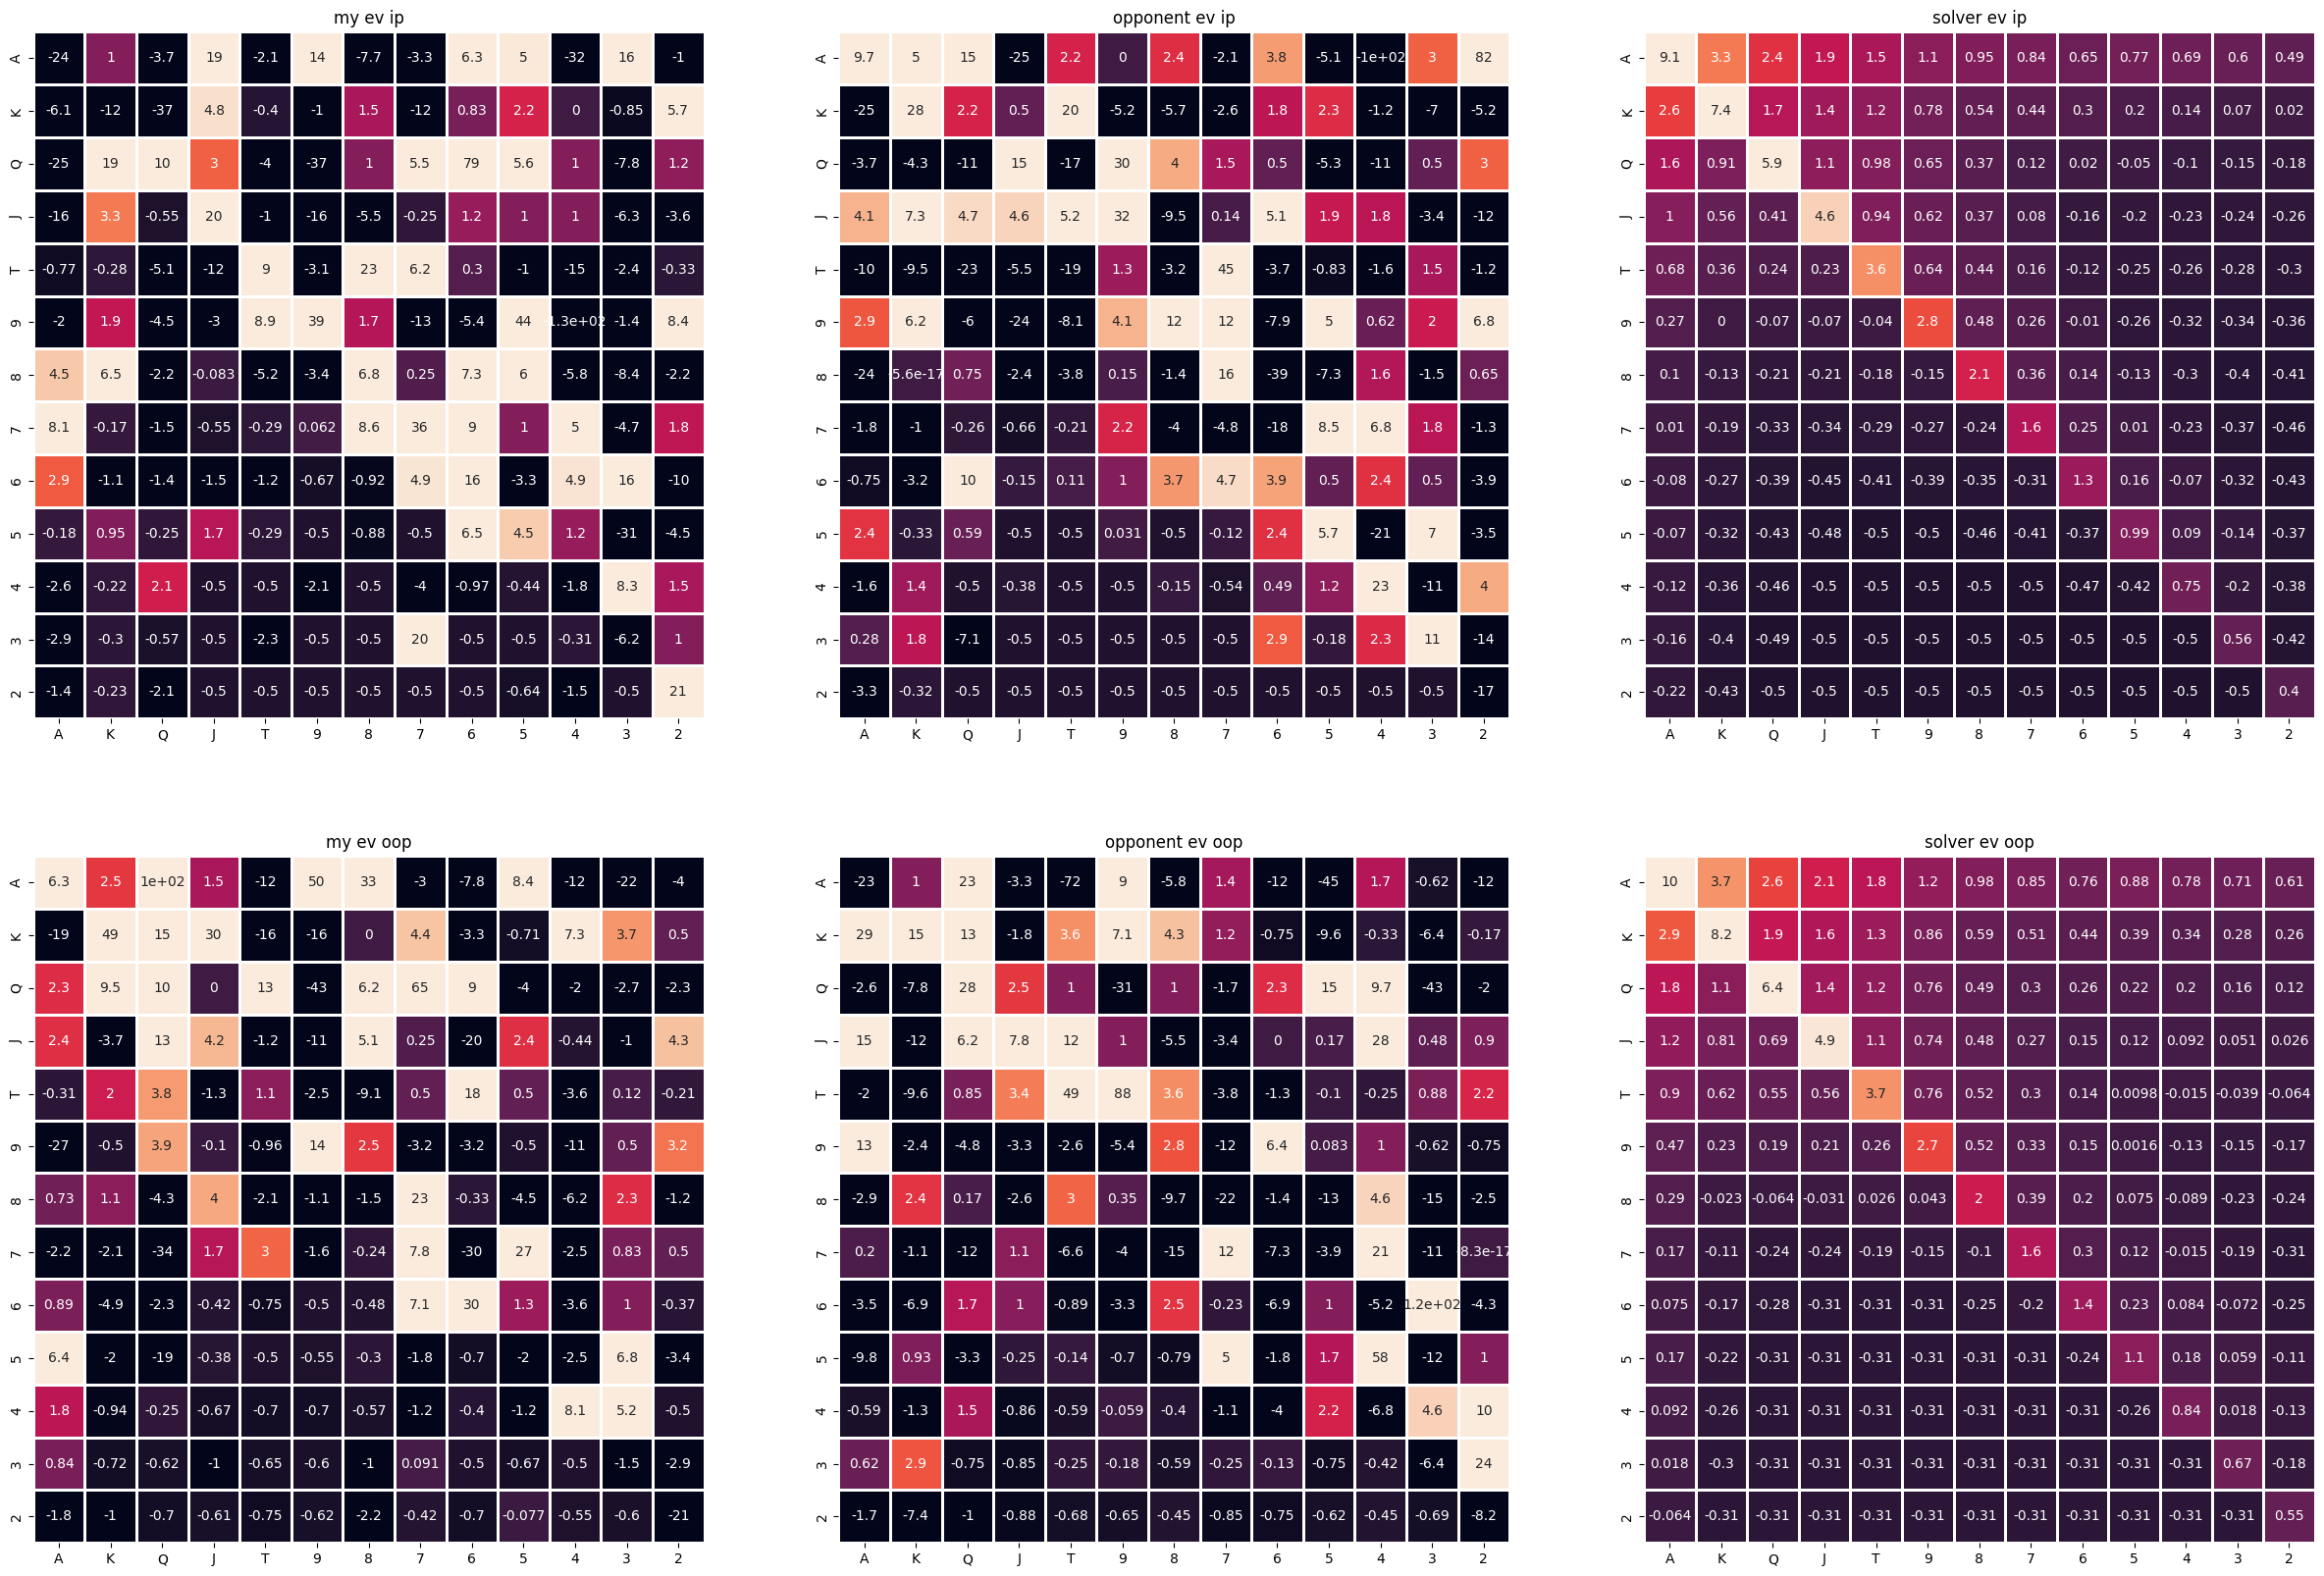

In [200]:
fig, ax = plt.subplots(2, 3, figsize=(30,20)) 

display(my_hands_ip_ev, ax[0][0], 'my ev ip')
display(zond_hands_ip_ev, ax[0][1], 'opponent ev ip')
display(solver_ev_ip, ax[0][2], 'solver ev ip')

display(my_hands_oop_ev, ax[1][0], 'my ev oop')
display(zond_hands_oop_ev, ax[1][1], 'opponent ev oop')
display(solver_ev_oop, ax[1][2], 'solver ev oop')

Для упрощения задачи будем работать с диапазоном опен рейза и искать пограничные руки в нем.

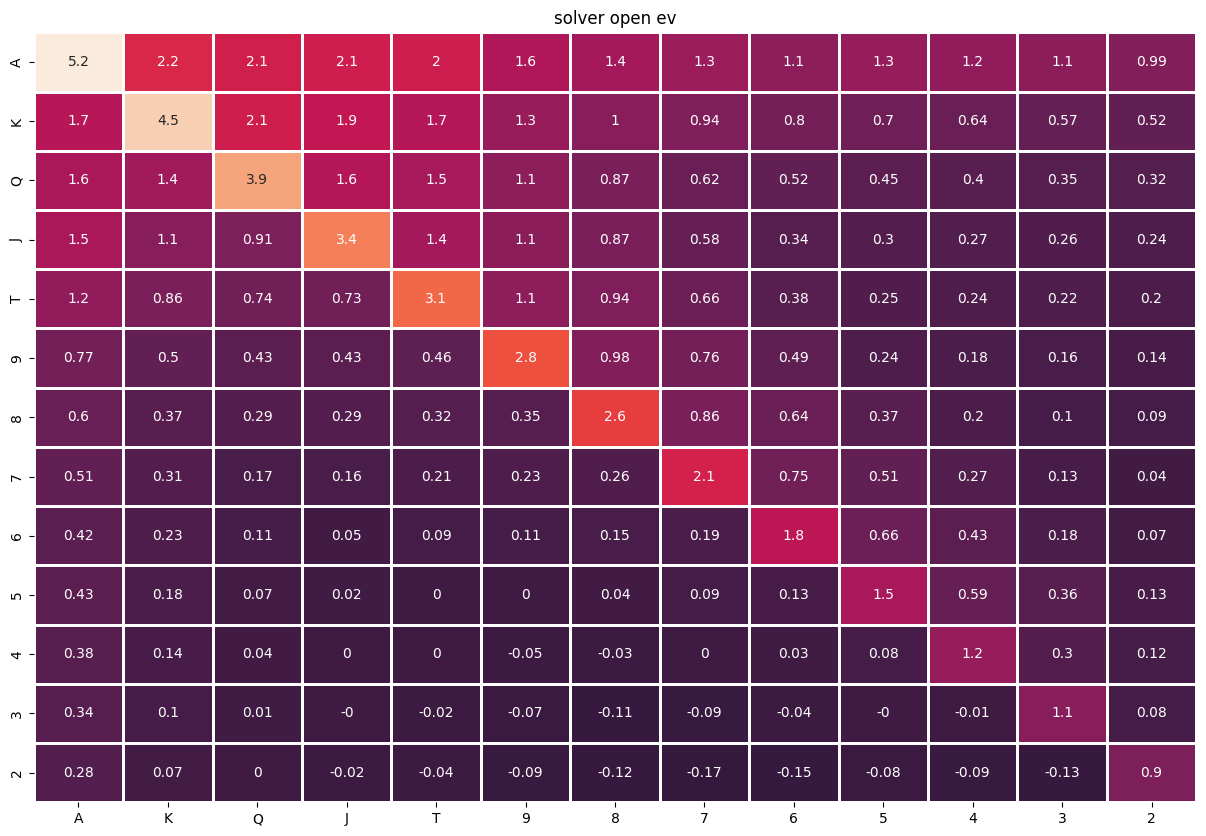

In [201]:
fig, ax = plt.subplots(figsize=(15, 10))
display(solver_open_ev, ax, 'solver open ev')

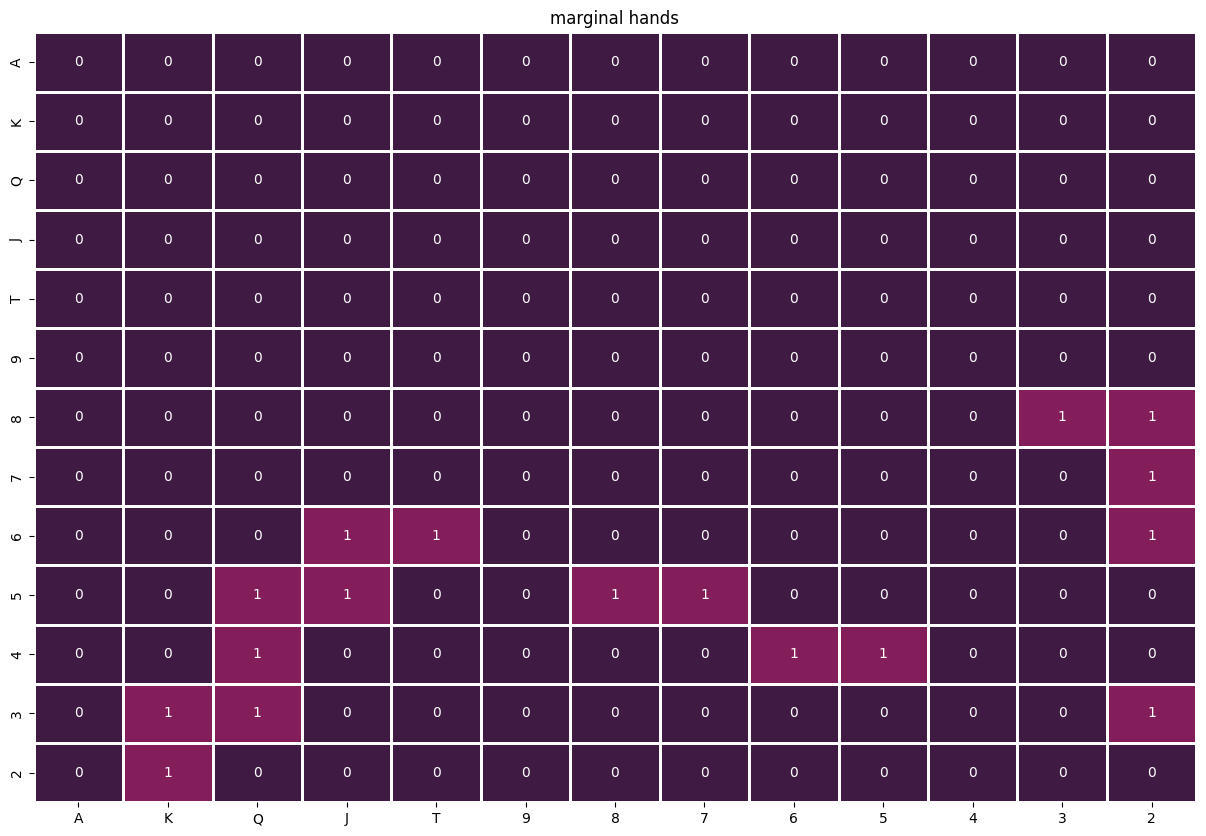

In [202]:
marginal = solver_open_ev.copy()
for i in range(len(cards)):
    for j in range(len(cards)):
        ev = marginal.loc[cards[i]].iloc[j]
        if ev <= 0.1 and ev > -0:
            marginal.loc[cards[i]].iloc[j] = 1
        else:
            marginal.loc[cards[i]].iloc[j] = 0
fig, ax = plt.subplots(figsize=(15, 10))
display(marginal, ax, 'marginal hands')

In [203]:
marginal_matrix = marginal.to_numpy()
my_marginal_ev = my_hands_ip_ev * marginal_matrix
zond_marginal_ev = zond_hands_ip_ev * marginal_matrix

In [204]:
my_marginal_ev -= marginal_matrix * solver_ev_ip.to_numpy()
zond_marginal_ev -= marginal_matrix * solver_ev_ip.to_numpy()

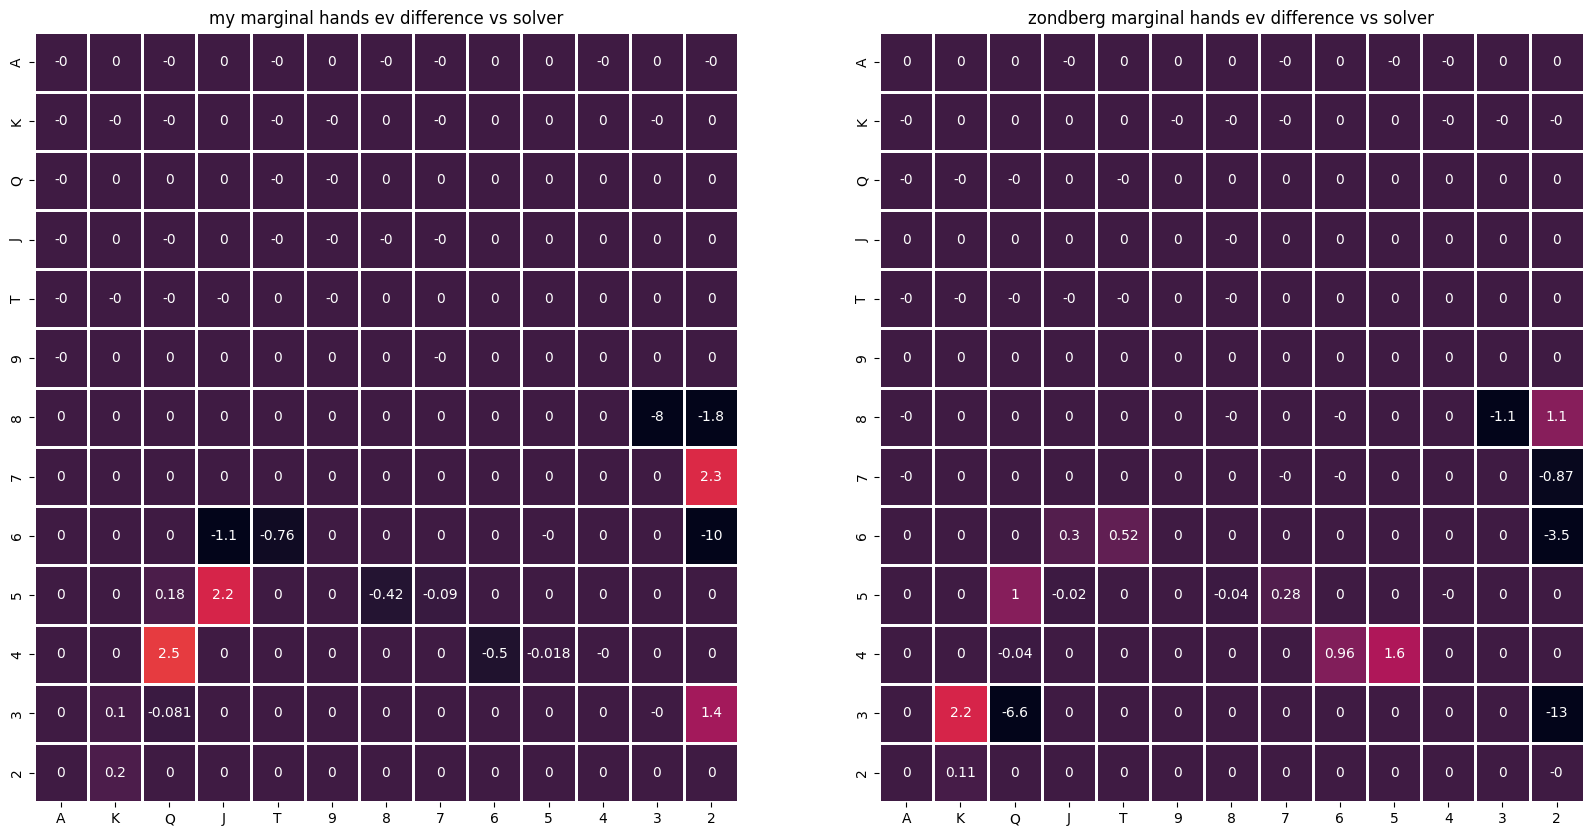

In [205]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
display(my_marginal_ev, ax[0], 'my marginal hands ev difference vs solver')
display(zond_marginal_ev, ax[1], 'zondberg marginal hands ev difference vs solver')

In [206]:
print(np.sum(np.sum(my_marginal_ev)))
print(np.sum(np.sum(zond_marginal_ev)))

-13.66934523809524
-17.54369463869464


#### Результат анализа первой гипотезы

Первую гипотезу (о матожиданиии пограничных рук) можем считать подтвержденной. Для обоих игроков среднее количество выигранных денег с пограничными руками оказалось меньше солверного матожидания, что подтверждает гипотезу.

### Анализ второй гипотезы

#### Диапазоны открытия

Перейдем к анализу второй гипотезы. У нас уже есть пограничные руки, осталось посмотреть, как выглядят солверные частоты открытия с ними и как выглядят наши с Даней.

In [207]:
def extract(indicator, indicator_total, df_line, df_hand=pd.DataFrame([])):
    '''
    returns overall frequency of indicator in indicator_total slice of df
    and range with each hand frequency
    '''
    frequency = np.sum(df_line.apply(indicator)) / np.sum(df_line.apply(indicator_total))
    if df_hand.empty:
        return frequency
    
    d1, d2 = {}, {}
    lines = df_line.to_list()
    hs = df_hand.to_list()
    # print(lines)
    # print(hs)
    for i, line in enumerate(lines):
        if not indicator_total(line):
            continue
        h = hs[i]
        # print(line, h)
        if h == '-':
            continue
        if indicator(line):
            d1[h] = d1.get(h, 0.0) + 1.0
        else:
            d2[h] = d2.get(h, 0.0) + 1.0
    result = Range()
    # print(d1)
    # print(d2)
    # print(result.d.keys())
    for i1 in range(13):
        for i2 in range(i1, 13):
            c1, c2 = cards[i1], cards[i2]
            # offsuit
            total = 0
            done = 0
            for x1 in range(4):
                for x2 in range(4):
                    s1 = suits[x1]
                    s2 = suits[x2]
                    if c1+s1 == c2+s2 or s1 == s2:
                        continue
                    comb = c1+s1+c2+s2
                    total += d1.get(comb, 0) + d2.get(comb, 0)
                    done += d1.get(comb, 0)
            for x1 in range(4):
                for x2 in range(4):
                    s1 = suits[x1]
                    s2 = suits[x2]
                    if c1+s1 == c2+s2 or s1 == s2:
                        continue
                    comb = c1+s1+c2+s2
                    if total == 0:
                        continue
                    result.set(comb, done/total)
            #suited
            total = 0
            done = 0
            for s in suits:
                if c1 == c2:
                    continue
                comb = c1+s+c2+s
                total += d1.get(comb, 0) + d2.get(comb, 0)
                done += d1.get(comb, 0)
            for s in suits:
                if c1 == c2:
                    continue
                comb = c1+s+c2+s
                if total == 0:
                    continue
                result.set(comb, done/total)

    return frequency, result



In [208]:
def is_opened(line):
    preflop = line.split('-')[0]
    return preflop.startswith('b')

def total(line):
    return True

zond_open, zond_open_range = extract(is_opened, total, oop['Line'], oop['Opponent hand'])
my_open, my_open_range = extract(is_opened, total, ip['Line'], ip['Hero hand'])
# zond_open = np.sum(oop['Line'].apply(is_opened)) / total_oop

print(f'zond open raise: {zond_open * 100 : .02f}%')
print(f'my open raise: {(my_open) * 100 : .02f}%')
# print(zond_open_range)
# print(my_open_range)
print('-----------------------------------------')

def is_defended(line):
    preflop = line.split('-')[0]
    return preflop.startswith('bc')

zond_defend, zond_defend_range = extract(is_defended, is_opened, ip['Line'], ip['Opponent hand'])
my_defend , my_defend_range = extract(is_defended, is_opened, oop['Line'], oop['Hero hand'])
# zond_open = np.sum(oop['Line'].apply(is_opened)) / total_oop

print(f'zond defense: {zond_defend * 100 : .02f}%')
print(f'my defense: {(my_defend) * 100 : .02f}%')
zond_open_range.df.round(2)


zond open raise:  69.61%
my open raise:  67.43%
-----------------------------------------
zond defense:  43.25%
my defense:  41.32%


,A,K,Q,J,T,9,8,7,6,5,4,3,2
A,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
K,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
Q,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
J,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,0.83,0.89,1.00
T,1.00,1.00,1.00,0.94,0.80,1.00,1.0,1.00,1.00,1.00,0.50,0.50,1.00
9,0.95,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,0.75,1.00
8,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,0.75,0.75
7,1.00,1.00,0.89,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,0.86
6,1.00,1.00,0.64,0.31,0.11,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
5,1.00,0.67,0.56,0.00,0.00,0.12,0.0,0.25,0.92,1.00,1.00,1.00,1.00


#### Парсинг солверного диапазона

In [209]:
def find_range_freq(email, password, url):
    driver = webdriver.Chrome()
    try:
        driver.get('https://app.gtobase.com/')

        time.sleep(1)

        email_xpath = '//*[@id="basic_username"]'
        password_xpath = '//*[@id="basic_password"]'
        submit_button_xpath = '//*[@id="basic"]/div[4]/div/div/div/div/button'

        email_element = driver.find_element(By.XPATH, email_xpath)
        email_element.clear()
        email_element.send_keys(email)

        password_element = driver.find_element(By.XPATH, password_xpath)
        password_element.clear()
        password_element.send_keys(password)

        driver.find_element(By.XPATH, submit_button_xpath).click()

        time.sleep(12)

        driver.execute_script(f"window.open('{url}');")
        driver.switch_to.window(driver.window_handles[1])

        time.sleep(5)

        table_xpath = "/html/body/div/div/div[2]/div/div/div[1]/div[1]/div[1]/div[2]/div/div[1]/table"
        table = driver.find_element(By.XPATH, table_xpath)

        rows = table.find_elements(By.TAG_NAME, "tr")
        result_matrix = []

        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            row_data = []
            for cell in cells:
                style = cell.get_attribute("style")
                background_size = None
                if "background-size" in style:
                    background_size = style.split("background-size: ")[1].split(",")[0].split()[0]

                    freq_s = background_size
                    if freq_s:
                        f = float(freq_s.split('%')[0])/100
                        row_data.append(f)
                    else:
                        row_data.append(0.0)


            result_matrix.append(row_data)
    except:
        driver.quit()
        return 0

    driver.quit()
    return result_matrix

def parse_gto_freq(l):
    matrix = find_range_freq(usrname, passwrd, l)
    return matrix



def display_freq(matrix, ax, title):
    sns.heatmap(matrix, linewidths=1, annot=True, ax=ax, vmin=0, vmax=1, cbar=False, cmap='crest')
    ax.set_title(title)

In [268]:
link_open =  'https://app.gtobase.com/viewer?id=107&q=100#onePlayer-strategy'

filename = 'solver_open_frequencies.csv'
parse = True
if parse:
    matrix_open = parse_gto_freq(link_open)
    solver_open_freq = pd.DataFrame(matrix_open, index=cards, columns=cards)
    solver_open_freq =  1 - solver_open_freq.round(2)
    solver_open_freq.to_csv(filename, index=False)
else:
    solver_open_freq = pd.read_csv(filename)
    solver_open_freq.index = cards

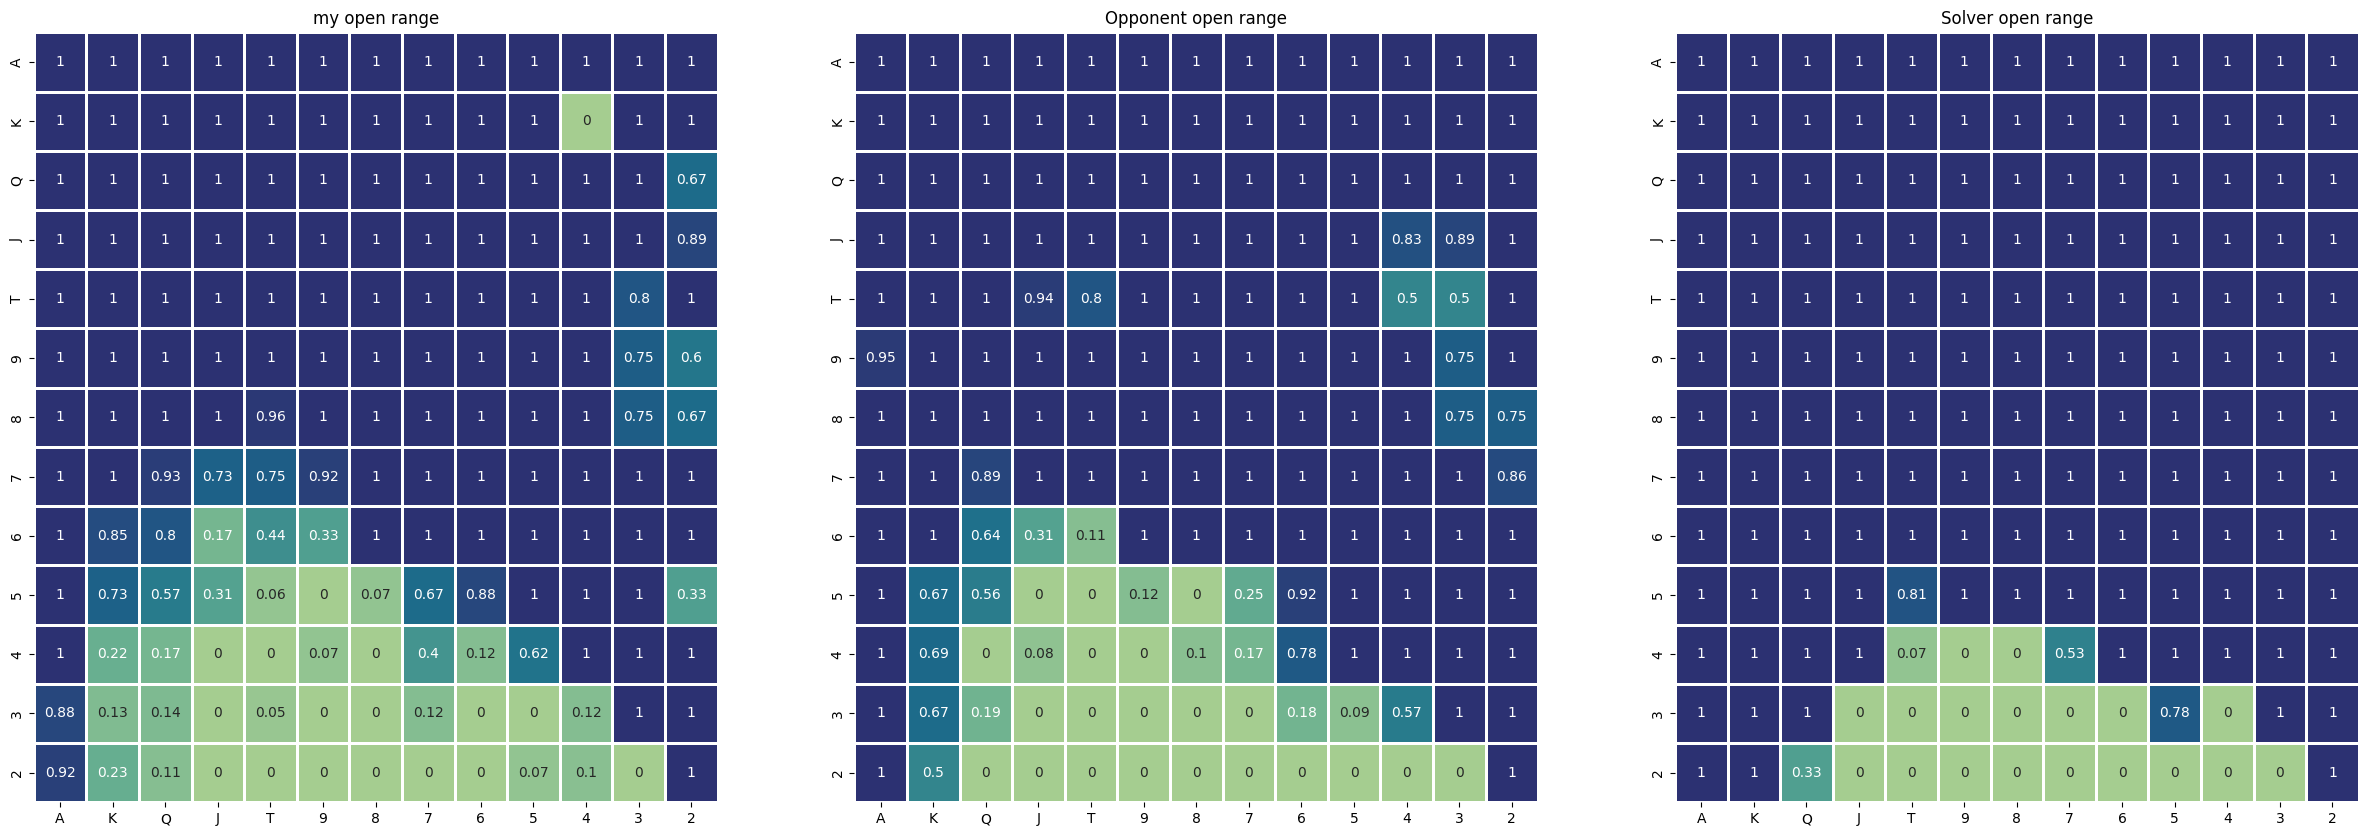

In [269]:
fig, ax = plt.subplots(1, 3,figsize=(30, 10))
display_freq(my_open_range.df.round(2), ax[0], 'my open range')
display_freq(zond_open_range.df.round(2), ax[1], 'Opponent open range')
display_freq(solver_open_freq, ax[2], 'Solver open range')

#### Посмотрим на частоты на маргинальных руках

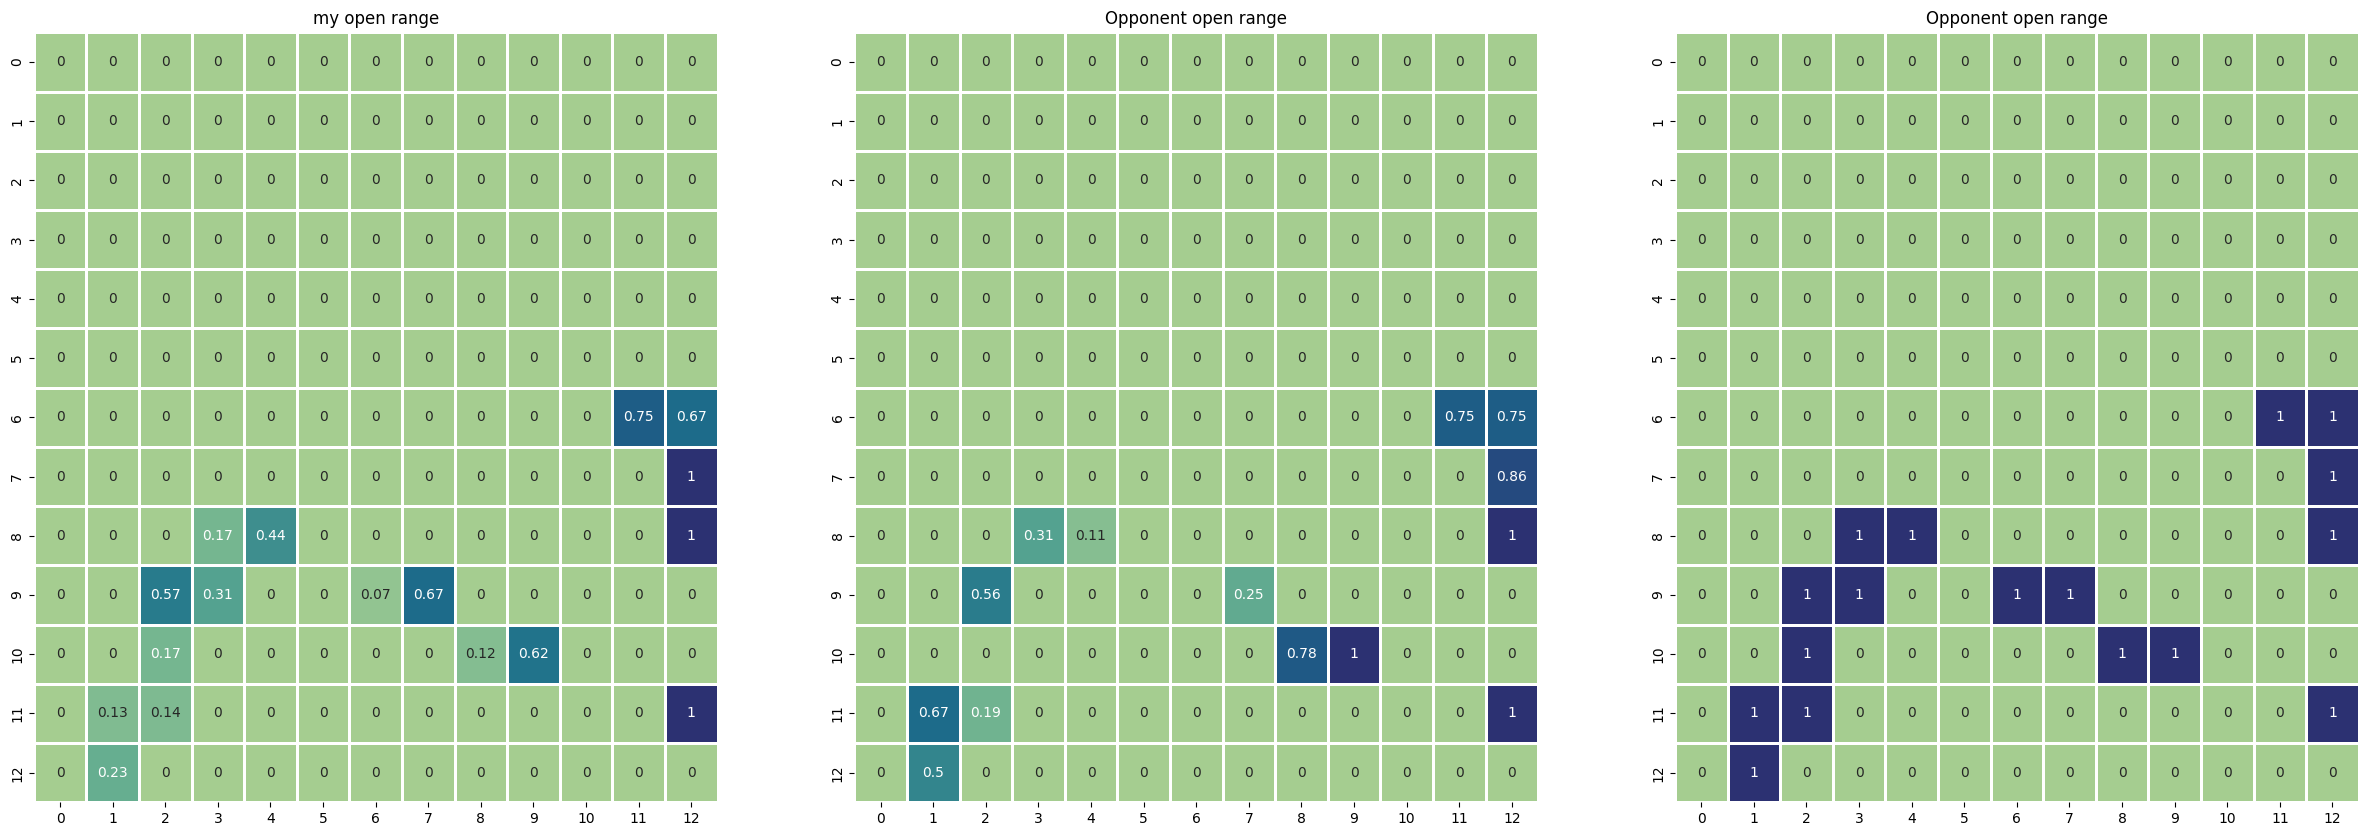

In [212]:
zond_open_matrix = zond_open_range.df.round(2).to_numpy() * marginal_matrix
my_open_matrix = my_open_range.df.round(2).to_numpy() * marginal_matrix
solver_open_matrix = solver_open_freq.to_numpy() * marginal_matrix


fig, ax = plt.subplots(1, 3,figsize=(30, 10))
display_freq(my_open_matrix, ax[0], 'my open range')
display_freq(zond_open_matrix, ax[1], 'Opponent open range')
display_freq(solver_open_matrix, ax[2], 'Opponent open range')

#### Результат анализа второй гипотезы

Логично, что солвер открывает все руки, матожидание которых положительно в равновесной стратегии. Как видно на наших с Даней визуализациях, мы это делаем не всегда, что подтверждает вторую гипотезу.

### Остальные префлоп характеристики

In [213]:
def is_3bet(line):
    preflop = line.split('-')[0]
    return preflop.startswith('br')

zond_3bet , zond_3bet_range = extract(is_3bet, is_opened, ip['Line'], ip['Opponent hand'])
my_3bet , my_3bet_range = extract(is_3bet, is_opened, oop['Line'], oop['Hero hand'])

print(f'zond 3bet: {zond_3bet * 100 : .02f}%')
print(f'my 3bet: {(my_3bet) * 100 : .02f}%')
print('-----------------------------------------')

def is_defended_3bet(line):
    preflop = line.split('-')[0]
    return preflop.startswith('brc')

zond_defend_3bet , zond_defend_3bet_range = extract(is_defended_3bet, is_3bet, oop['Line'], oop['Opponent hand'])
my_defend_3bet , my_defend_3bet_range = extract(is_defended_3bet, is_3bet, ip['Line'], ip['Hero hand'])
# zond_open = np.sum(oop['Line'].apply(is_opened)) / total_oop

print(f'zond defense vs 3bet: {zond_defend_3bet * 100 : .02f}%')
print(f'my defense vs 3bet: {(my_defend_3bet) * 100 : .02f}%')

zond 3bet:  26.79%
my 3bet:  20.10%
-----------------------------------------
zond defense vs 3bet:  35.35%
my defense vs 3bet:  40.94%


In [214]:
def is_4bet(line):
    preflop = line.split('-')[0]
    return preflop.startswith('brr')

zond_4bet,  zond_4bet_range = extract(is_4bet, is_3bet, oop['Line'], oop['Opponent hand'])
my_4bet, my_4bet_range = extract(is_4bet, is_3bet, ip['Line'], ip['Hero hand'])

print(f'zond 4bet: {zond_4bet * 100 : .02f}%')
print(f'my 4bet: {(my_4bet) * 100 : .02f}%')
print('-----------------------------------------')

def is_defended_4bet(line):
    preflop = line.split('-')[0]
    return preflop.startswith('brrc')

zond_defend_4bet , zond_defend_4bet_range = extract(is_defended_4bet, is_4bet, ip['Line'], ip['Opponent hand'])
my_defend_4bet , my_defend_4bet_range = extract(is_defended_4bet, is_4bet, oop['Line'], oop['Hero hand'])
# print(zond_4bet_range)
# print(my_4bet_range)

print(f'zond defense vs 4bet: {zond_defend_4bet * 100 : .02f}%')
print(f'my defense vs 4bet: {(my_defend_4bet) * 100 : .02f}%')

zond 4bet:  24.75%
my 4bet:  10.24%
-----------------------------------------
zond defense vs 4bet:  65.38%
my defense vs 4bet:  57.14%


In [215]:
def is_5bet(line):
    preflop = line.split('-')[0]
    return preflop.startswith('brrr')

zond_5bet , zond_5bet_range = extract(is_5bet, is_4bet, ip['Line'], ip['Opponent hand'])
my_5bet , my_5bet_range = extract(is_5bet, is_4bet, oop['Line'], oop['Hero hand'])

print(f'zond 5bet: {zond_5bet * 100 : .02f}%')
print(f'my 5bet: {(my_5bet) * 100 : .02f}%')
# print('-----------------------------------------')
# print(zond_5bet_range)
def is_defended_5bet(line):
    preflop = line.split('-')[0]
    return preflop.startswith('brrrc')

zond_defend_5bet, zond_defend_5bet_range = extract(is_defended_5bet, is_5bet, oop['Line'], oop['Opponent hand'])
my_defend_5bet, my_defend_5bet_range= extract(is_defended_5bet, is_5bet, ip['Line'], ip['Hero hand'])

print(f'zond defense vs 5bet: {zond_defend_5bet * 100 : .02f}%')
print(f'my defense vs 5bet: {(my_defend_5bet) * 100 : .02f}%')

zond 5bet:  7.69%
my 5bet:  20.41%
zond defense vs 5bet:  60.00%
my defense vs 5bet:  50.00%


In [216]:
print('Final results')
print("Hero")
print(f"opening: {my_open*100:.01f}%   call: {my_defend*100:.01f}%   3bet: {my_3bet*100:.01f}%")
print(f"f3bet  : {(1-(my_defend_3bet + my_4bet))*100:.01f}%   4bet: {my_4bet*100:.01f}%   "
      f"f4bet: {(1 - (my_5bet +my_defend_4bet))*100:.01f}%")
print("------------------------------------------")
print("Zondberg")
print(f"opening: {zond_open*100:.01f}%   call: {zond_defend*100:.01f}%   3bet: {zond_3bet*100:.01f}%")
print(f"f3bet  : {(1-(zond_defend_3bet + zond_4bet))*100:.01f}%   4bet: {zond_4bet*100:.01f}%   "
      f"f4bet: {(1 - (zond_5bet +zond_defend_4bet))*100:.01f}%")
print("------------------------------------------")
print("Optimal")
print(f"opening: {81.48:.01f}%   call: {46.77:.01f}%   3bet: {23.64:.01f}%")
print(f"f3bet  : {53.75:.01f}%   4bet: {8.63:.01f}%   "
      f"f4bet: {39.55:.01f}%")

Final results
Hero
opening: 67.4%   call: 41.3%   3bet: 20.1%
f3bet  : 48.8%   4bet: 10.2%   f4bet: 22.4%
------------------------------------------
Zondberg
opening: 69.6%   call: 43.2%   3bet: 26.8%
f3bet  : 39.9%   4bet: 24.7%   f4bet: 26.9%
------------------------------------------
Optimal
opening: 81.5%   call: 46.8%   3bet: 23.6%
f3bet  : 53.8%   4bet: 8.6%   f4bet: 39.5%


Вторая гипотеза принимается, это 

### Диапазоны

In [217]:
print(my_open_range)

AsAh,AsAd,AsAc,AsKs,AsKh,AsKd,AsKc,AsQs,AsQh,AsQd,AsQc,AsJs,AsJh,AsJd,AsJc,AsTs,AsTh,AsTd,AsTc,As9s,As9h,As9d,As9c,As8s,As8h,As8d,As8c,As7s,As7h,As7d,As7c,As6s,As6h,As6d,As6c,As5s,As5h,As5d,As5c,As4s,As4h,As4d,As4c,As3s,As3h:0.875,As3d:0.875,As3c:0.875,As2s,As2h:0.9166666666666666,As2d:0.9166666666666666,As2c:0.9166666666666666,AhAd,AhAc,AhKs,AhKh,AhKd,AhKc,AhQs,AhQh,AhQd,AhQc,AhJs,AhJh,AhJd,AhJc,AhTs,AhTh,AhTd,AhTc,Ah9s,Ah9h,Ah9d,Ah9c,Ah8s,Ah8h,Ah8d,Ah8c,Ah7s,Ah7h,Ah7d,Ah7c,Ah6s,Ah6h,Ah6d,Ah6c,Ah5s,Ah5h,Ah5d,Ah5c,Ah4s,Ah4h,Ah4d,Ah4c,Ah3s:0.875,Ah3h,Ah3d:0.875,Ah3c:0.875,Ah2s:0.9166666666666666,Ah2h,Ah2d:0.9166666666666666,Ah2c:0.9166666666666666,AdAc,AdKs,AdKh,AdKd,AdKc,AdQs,AdQh,AdQd,AdQc,AdJs,AdJh,AdJd,AdJc,AdTs,AdTh,AdTd,AdTc,Ad9s,Ad9h,Ad9d,Ad9c,Ad8s,Ad8h,Ad8d,Ad8c,Ad7s,Ad7h,Ad7d,Ad7c,Ad6s,Ad6h,Ad6d,Ad6c,Ad5s,Ad5h,Ad5d,Ad5c,Ad4s,Ad4h,Ad4d,Ad4c,Ad3s:0.875,Ad3h:0.875,Ad3d,Ad3c:0.875,Ad2s:0.9166666666666666,Ad2h:0.9166666666666666,Ad2d,Ad2c:0.9166666666666666,AcKs,AcKh,AcKd,AcKc,AcQs,

In [218]:
print(zond_open_range)

AsAh,AsAd,AsAc,AsKs,AsKh,AsKd,AsKc,AsQs,AsQh,AsQd,AsQc,AsJs,AsJh,AsJd,AsJc,AsTs,AsTh,AsTd,AsTc,As9s,As9h:0.95,As9d:0.95,As9c:0.95,As8s,As8h,As8d,As8c,As7s,As7h,As7d,As7c,As6s,As6h,As6d,As6c,As5s,As5h,As5d,As5c,As4s,As4h,As4d,As4c,As3s,As3h,As3d,As3c,As2s,As2h,As2d,As2c,AhAd,AhAc,AhKs,AhKh,AhKd,AhKc,AhQs,AhQh,AhQd,AhQc,AhJs,AhJh,AhJd,AhJc,AhTs,AhTh,AhTd,AhTc,Ah9s:0.95,Ah9h,Ah9d:0.95,Ah9c:0.95,Ah8s,Ah8h,Ah8d,Ah8c,Ah7s,Ah7h,Ah7d,Ah7c,Ah6s,Ah6h,Ah6d,Ah6c,Ah5s,Ah5h,Ah5d,Ah5c,Ah4s,Ah4h,Ah4d,Ah4c,Ah3s,Ah3h,Ah3d,Ah3c,Ah2s,Ah2h,Ah2d,Ah2c,AdAc,AdKs,AdKh,AdKd,AdKc,AdQs,AdQh,AdQd,AdQc,AdJs,AdJh,AdJd,AdJc,AdTs,AdTh,AdTd,AdTc,Ad9s:0.95,Ad9h:0.95,Ad9d,Ad9c:0.95,Ad8s,Ad8h,Ad8d,Ad8c,Ad7s,Ad7h,Ad7d,Ad7c,Ad6s,Ad6h,Ad6d,Ad6c,Ad5s,Ad5h,Ad5d,Ad5c,Ad4s,Ad4h,Ad4d,Ad4c,Ad3s,Ad3h,Ad3d,Ad3c,Ad2s,Ad2h,Ad2d,Ad2c,AcKs,AcKh,AcKd,AcKc,AcQs,AcQh,AcQd,AcQc,AcJs,AcJh,AcJd,AcJc,AcTs,AcTh,AcTd,AcTc,Ac9s:0.95,Ac9h:0.95,Ac9d:0.95,Ac9c,Ac8s,Ac8h,Ac8d,Ac8c,Ac7s,Ac7h,Ac7d,Ac7c,Ac6s,Ac6h,Ac6d,Ac6c,Ac5s,Ac5h,Ac5d,Ac5c,Ac4s,Ac4h,

![my open range](./data/my_open.png "my")  ![zondberg open range](./data/zond_open.png "zondberg") 

In [219]:
print(my_3bet_range)

AsAh,AsAd,AsAc,AsKs,AsKh,AsKd,AsKc,AsQs,AsQh,AsQd,AsQc,AsJs,AsJh:0.6363636363636364,AsJd:0.6363636363636364,AsJc:0.6363636363636364,AsTs,AsTh:0.4,AsTd:0.4,AsTc:0.4,As9s,As9h:0.35714285714285715,As9d:0.35714285714285715,As9c:0.35714285714285715,As8s,As8h:0.07692307692307693,As8d:0.07692307692307693,As8c:0.07692307692307693,As7s:0.6666666666666666,As6s:0.75,As5s:0.5,As5h:0.375,As5d:0.375,As5c:0.375,As4s,As3s:0.5,AhAd,AhAc,AhKs,AhKh,AhKd,AhKc,AhQs,AhQh,AhQd,AhQc,AhJs:0.6363636363636364,AhJh,AhJd:0.6363636363636364,AhJc:0.6363636363636364,AhTs:0.4,AhTh,AhTd:0.4,AhTc:0.4,Ah9s:0.35714285714285715,Ah9h,Ah9d:0.35714285714285715,Ah9c:0.35714285714285715,Ah8s:0.07692307692307693,Ah8h,Ah8d:0.07692307692307693,Ah8c:0.07692307692307693,Ah7h:0.6666666666666666,Ah6h:0.75,Ah5s:0.375,Ah5h:0.5,Ah5d:0.375,Ah5c:0.375,Ah4h,Ah3h:0.5,AdAc,AdKs,AdKh,AdKd,AdKc,AdQs,AdQh,AdQd,AdQc,AdJs:0.6363636363636364,AdJh:0.6363636363636364,AdJd,AdJc:0.6363636363636364,AdTs:0.4,AdTh:0.4,AdTd,AdTc:0.4,Ad9s:0.3571428571428571

In [220]:
print(zond_3bet_range)

AsAh,AsAd,AsAc,AsKs,AsKh,AsKd,AsKc,AsQs,AsQh,AsQd,AsQc,AsJs,AsJh,AsJd,AsJc,AsTs,AsTh,AsTd,AsTc,As9h:0.2222222222222222,As9d:0.2222222222222222,As9c:0.2222222222222222,As8s:0.8333333333333334,As7s:0.6,As6s:0.8571428571428571,As5s,As4s:0.6666666666666666,As3s,As2s,AhAd,AhAc,AhKs,AhKh,AhKd,AhKc,AhQs,AhQh,AhQd,AhQc,AhJs,AhJh,AhJd,AhJc,AhTs,AhTh,AhTd,AhTc,Ah9s:0.2222222222222222,Ah9d:0.2222222222222222,Ah9c:0.2222222222222222,Ah8h:0.8333333333333334,Ah7h:0.6,Ah6h:0.8571428571428571,Ah5h,Ah4h:0.6666666666666666,Ah3h,Ah2h,AdAc,AdKs,AdKh,AdKd,AdKc,AdQs,AdQh,AdQd,AdQc,AdJs,AdJh,AdJd,AdJc,AdTs,AdTh,AdTd,AdTc,Ad9s:0.2222222222222222,Ad9h:0.2222222222222222,Ad9c:0.2222222222222222,Ad8d:0.8333333333333334,Ad7d:0.6,Ad6d:0.8571428571428571,Ad5d,Ad4d:0.6666666666666666,Ad3d,Ad2d,AcKs,AcKh,AcKd,AcKc,AcQs,AcQh,AcQd,AcQc,AcJs,AcJh,AcJd,AcJc,AcTs,AcTh,AcTd,AcTc,Ac9s:0.2222222222222222,Ac9h:0.2222222222222222,Ac9d:0.2222222222222222,Ac8c:0.8333333333333334,Ac7c:0.6,Ac6c:0.8571428571428571,Ac5c,Ac4c:0.66666

In [221]:
print(my_4bet_range)

AsKh:0.6,AsKd:0.6,AsKc:0.6,AsQh:0.75,AsQd:0.75,AsQc:0.75,As5h:0.6666666666666666,As5d:0.6666666666666666,As5c:0.6666666666666666,As3h:0.5,As3d:0.5,As3c:0.5,AhKs:0.6,AhKd:0.6,AhKc:0.6,AhQs:0.75,AhQd:0.75,AhQc:0.75,Ah5s:0.6666666666666666,Ah5d:0.6666666666666666,Ah5c:0.6666666666666666,Ah3s:0.5,Ah3d:0.5,Ah3c:0.5,AdKs:0.6,AdKh:0.6,AdKc:0.6,AdQs:0.75,AdQh:0.75,AdQc:0.75,Ad5s:0.6666666666666666,Ad5h:0.6666666666666666,Ad5c:0.6666666666666666,Ad3s:0.5,Ad3h:0.5,Ad3c:0.5,AcKs:0.6,AcKh:0.6,AcKd:0.6,AcQs:0.75,AcQh:0.75,AcQd:0.75,Ac5s:0.6666666666666666,Ac5h:0.6666666666666666,Ac5d:0.6666666666666666,Ac3s:0.5,Ac3h:0.5,Ac3d:0.5,KsKh,KsKd,KsKc,KsQs:0.3333333333333333,KsJh:0.14285714285714285,KsJd:0.14285714285714285,KsJc:0.14285714285714285,KsTs:0.5,Ks8h:0.1111111111111111,Ks8d:0.1111111111111111,Ks8c:0.1111111111111111,KhKd,KhKc,KhQh:0.3333333333333333,KhJs:0.14285714285714285,KhJd:0.14285714285714285,KhJc:0.14285714285714285,KhTh:0.5,Kh8s:0.1111111111111111,Kh8d:0.1111111111111111,Kh8c:0.11111111

In [222]:
print(zond_4bet_range)

AsAh,AsAd,AsAc,AsKh,AsKd,AsKc,AsQs,AsQh:0.75,AsQd:0.75,AsQc:0.75,AsJh:0.6666666666666666,AsJd:0.6666666666666666,AsJc:0.6666666666666666,As9h:0.2,As9d:0.2,As9c:0.2,As8h:0.75,As8d:0.75,As8c:0.75,As7h,As7d,As7c,AhAd,AhAc,AhKs,AhKd,AhKc,AhQs:0.75,AhQh,AhQd:0.75,AhQc:0.75,AhJs:0.6666666666666666,AhJd:0.6666666666666666,AhJc:0.6666666666666666,Ah9s:0.2,Ah9d:0.2,Ah9c:0.2,Ah8s:0.75,Ah8d:0.75,Ah8c:0.75,Ah7s,Ah7d,Ah7c,AdAc,AdKs,AdKh,AdKc,AdQs:0.75,AdQh:0.75,AdQd,AdQc:0.75,AdJs:0.6666666666666666,AdJh:0.6666666666666666,AdJc:0.6666666666666666,Ad9s:0.2,Ad9h:0.2,Ad9c:0.2,Ad8s:0.75,Ad8h:0.75,Ad8c:0.75,Ad7s,Ad7h,Ad7c,AcKs,AcKh,AcKd,AcQs:0.75,AcQh:0.75,AcQd:0.75,AcQc,AcJs:0.6666666666666666,AcJh:0.6666666666666666,AcJd:0.6666666666666666,Ac9s:0.2,Ac9h:0.2,Ac9d:0.2,Ac8s:0.75,Ac8h:0.75,Ac8d:0.75,Ac7s,Ac7h,Ac7d,KsKh,KsKd,KsKc,KsQs:0.5,KsTs:0.5,KsTh:0.5,KsTd:0.5,KsTc:0.5,KhKd,KhKc,KhQh:0.5,KhTs:0.5,KhTh:0.5,KhTd:0.5,KhTc:0.5,KdKc,KdQd:0.5,KdTs:0.5,KdTh:0.5,KdTd:0.5,KdTc:0.5,KcQc:0.5,KcTs:0.5,KcTh:0.5,Kc

# Постфлоп

На постфлопе сравним с солверными частоты чек рейзов, конбетов, фолдов на конбет, проббетов, фолдов на проббет, лидов и задержанных конбетов.

**Гипотеза первая**: АА является особенной рукой для любого покериста, и из-за этого ее свойственно переигрывать. В связи с чем матожодание этой руки будет хуже, чем других рук из этого класса.

## Анализ первой гипотезы

### Подготовка данных

In [246]:
def aces(s):
    c1, c2 = s[0], s[2]
    return c1 == 'A' and c2 == 'A'

zond_aces = df[df['Opponent hand'].apply(aces)]
my_aces = df[df['Hero hand'].apply(aces)]

In [247]:
my_aces = my_aces[my_aces['Runout'] != '-']
zond_aces = zond_aces[zond_aces['Runout'] != '-']

print(len(zond_aces))
print(len(my_aces))

my_aces

7
4


,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout
377,2024-03-27 00:32:35,3bp,brc-bc-bc-bc,zondberg,330.0,461.7,hero,AsAd,AhAc,b3.0r15.0c-b15.0c-b80.0c-b220.0c,5cQd5d-3c-8c
19,2024-04-25 09:04:23,3bp,brc-bc-bf,hero,50.0,183.0,zondberg,AsAc,AhQc,b2.5r12.5c-b12.5c-b32.0f,3h9hJd-3s
217,2024-04-25 10:14:58,3bp,brc-xbc-xx-bf,hero,36.0,432.5,zondberg,AsAh,Td7d,b3.0r12.0c-xb6.0c-xx-b18.0f,5h4sKd-3s-4c
394,2024-04-25 11:15:01,srp,bc-xbrrf,hero,30.0,159.5,hero,AhAd,Jc3c,b3.0c-xb2.0r12.0r32.0f,4s2hTs


In [229]:
zond_aces.to_csv('zond_aces.csv', index=False)
my_aces.to_csv('my_aces.csv', index=False)

In [230]:
my_aces

,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout
377,2024-03-27 00:32:35,3bp,brc-bc-bc-bc,zondberg,330.0,461.7,hero,AsAd,AhAc,b3.0r15.0c-b15.0c-b80.0c-b220.0c,5cQd5d-3c-8c
19,2024-04-25 09:04:23,3bp,brc-bc-bf,hero,50.0,183.0,zondberg,AsAc,AhQc,b2.5r12.5c-b12.5c-b32.0f,3h9hJd-3s
217,2024-04-25 10:14:58,3bp,brc-xbc-xx-bf,hero,36.0,432.5,zondberg,AsAh,Td7d,b3.0r12.0c-xb6.0c-xx-b18.0f,5h4sKd-3s-4c
394,2024-04-25 11:15:01,srp,bc-xbrrf,hero,30.0,159.5,hero,AhAd,Jc3c,b3.0c-xb2.0r12.0r32.0f,4s2hTs


8 рук это на так много, поэтому попытаемся проанализировать их все с помощью солвера.

### Анализ с помощью солвера

In [258]:
my_aces['EV loss IP'] = [0 for i in range(4)]
zond_aces['EV loss IP'] = [0 for i in range(7)]
my_aces['EV loss OOP'] = [0 for i in range(4)]
zond_aces['EV loss OOP'] = [0 for i in range(7)]
my_aces

,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout,EV loss IP,EV loss OOP
0,2024-03-27 00:32:35,3bp,brc-bc-bc-bc,zondberg,330.0,461.7,hero,AsAd,AhAc,b3.0r15.0c-b15.0c-b80.0c-b220.0c,5cQd5d-3c-8c,0,0
1,2024-04-25 09:04:23,3bp,brc-bc-bf,hero,50.0,183.0,zondberg,AsAc,AhQc,b2.5r12.5c-b12.5c-b32.0f,3h9hJd-3s,0,0
2,2024-04-25 10:14:58,3bp,brc-xbc-xx-bf,hero,36.0,432.5,zondberg,AsAh,Td7d,b3.0r12.0c-xb6.0c-xx-b18.0f,5h4sKd-3s-4c,0,0
3,2024-04-25 11:15:01,srp,bc-xbrrf,hero,30.0,159.5,hero,AhAd,Jc3c,b3.0c-xb2.0r12.0r32.0f,4s2hTs,0,0


In [259]:
# my_aces.at[1, 'EV loss IP'] = 0.16
# my_aces.at[2, 'EV loss IP'] = 0.32
my_aces

,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout,EV loss IP,EV loss OOP
0,2024-03-27 00:32:35,3bp,brc-bc-bc-bc,zondberg,330.0,461.7,hero,AsAd,AhAc,b3.0r15.0c-b15.0c-b80.0c-b220.0c,5cQd5d-3c-8c,0,0
1,2024-04-25 09:04:23,3bp,brc-bc-bf,hero,50.0,183.0,zondberg,AsAc,AhQc,b2.5r12.5c-b12.5c-b32.0f,3h9hJd-3s,0,0
2,2024-04-25 10:14:58,3bp,brc-xbc-xx-bf,hero,36.0,432.5,zondberg,AsAh,Td7d,b3.0r12.0c-xb6.0c-xx-b18.0f,5h4sKd-3s-4c,0,0
3,2024-04-25 11:15:01,srp,bc-xbrrf,hero,30.0,159.5,hero,AhAd,Jc3c,b3.0c-xb2.0r12.0r32.0f,4s2hTs,0,0


In [260]:
zond_aces

,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout,EV loss IP,EV loss OOP
0,2024-03-22 02:02:18,3bp,brc-bc-bc-bc,hero,567.4,283.7,hero,9d5d,AhAc,b2.5r12.5c-b32.0c-b89.0c-b150.2c,7c3d5s-Jd-5h,0,0
1,2024-03-23 20:55:15,srp,bc-xbf,zondberg,5.0,93.8,zondberg,Jd4d,AsAd,b2.5c-xb1.5f,7hQsQc,0,0
2,2024-03-23 21:08:14,srp,bc-xbc-xbc-xbc,zondberg,75.0,290.5,zondberg,Ks7d,AhAd,b2.5c-xb5.0c-xb7.5c-xb22.5c,6c4h7s-6h-Ac,0,0
3,2024-03-26 23:19:14,srp,bc-xbc-xbc-xbf,zondberg,45.0,339.9,zondberg,KdJs,AsAd,b3.0c-xb4.5c-xb15.0c-xb45.0f,Th4c4d-5d-8c,0,0
4,2024-03-26 23:33:21,3bp,brc-brc-xx-xbf,hero,60.0,321.8,hero,Ad9d,AsAc,b3.0r12.0c-b4.0r18.0c-xx-xb45.0f,3hTh2h-6h-5d,0,0
5,2024-03-27 00:32:35,3bp,brc-bc-bc-bc,zondberg,330.0,461.7,hero,AsAd,AhAc,b3.0r15.0c-b15.0c-b80.0c-b220.0c,5cQd5d-3c-8c,0,0
6,2024-04-25 11:31:32,3bp,brc-bc-xx-bc,hero,181.6,167.0,hero,6h3h,AsAd,b3.0r12.0c-b8.0c-xx-b70.8c,7hKs5d-5h-Qh,0,0


In [261]:
# zond_aces.to_csv('zond_aces.csv', index=False)
# my_aces.to_csv('my_aces.csv', index=False)

Чтобы проанализировать все руки прогоним их через библиотеку решений при помощи `selenium`, который мы использовали ранее для парсинга диапазонов из `gtobase.com`.

In [234]:
import re
 
def parse_poker_line(driver, poker_line, hands_and_board):
    actions = re.findall(r'[brxcf]\d*\.?\d*-?', poker_line)
    hands = hands_and_board[:2]
    board = hands_and_board[2]
    url_base = 'https://app.gtobase.com/viewer?id=107&q=100'
    url_suffix = ""
    streets = ['F', 'T', 'R']
    street_index = 0
    results = []
 
    player_index = 0 if street_index == 0 else 1
    for action in actions:
        hand = hands[player_index]
        hand_code = f"{hand[0]}{hand[2]}" if hand[0] == hand[2] else f"{hand[0]}{hand[2]}o" if hand[0] != hand[2] and hand[1] != hand[3] else f"{hand[0]}{hand[2]}s"
        street = streets[street_index] if street_index < len(streets) else ""
        
        current_url = f"{url_base}{url_suffix}#onePlayer-strategy"
        driver.get(current_url)
        time.sleep(12)
        
        table = driver.find_element(By.XPATH, "/html/body/div[1]/div/div[2]/div/div/div[1]/div[1]/div[1]/div[2]/div/div[1]/table")
        cells = table.find_elements(By.TAG_NAME, "td")
        for cell in cells:
            if cell.text == hand_code:
                cell.click()
                break
    
        time.sleep(5)
        
        driver.find_element(By.XPATH, '/html/body/div[1]/div/div[2]/div/div/div[2]/div[6]/div[2]/div[1]/ul/li[2]').click()
        
        action_elements = driver.find_elements(By.XPATH, '/html/body/div[1]/div/div[2]/div/div/div[2]/div[6]/div[1]/div/div/div/div/div/div/div[1]/table/thead/tr/th')
        actions_list = []
        for element in action_elements[3:-1]:
            choice = element.get_attribute('aria-label')
            if choice != 'EqR':
                actions_list.append(choice)
 
        table = driver.find_element(By.XPATH, "/html/body/div[1]/div/div[2]/div/div/div[2]/div[6]/div[1]/div/div/div/div/div/div/div[2]/table/tbody")
        row = table.find_element(By.XPATH, f".//tr[@data-row-key='{hand}']")
        frequencies_elements = row.find_elements(By.CLASS_NAME, "ant-table-cell")
        
        frequencies_list = []
        
        for element in frequencies_elements[-len(actions_list):]:
            if element.text != '':
                frequencies_list.append(float(element.text))
        
        driver.find_element(By.XPATH, '/html/body/div[1]/div/div[2]/div/div/div[2]/div[6]/div[2]/div[1]/ul/li[3]').click()
 
        table = driver.find_element(By.XPATH, "/html/body/div[1]/div/div[2]/div/div/div[2]/div[6]/div[1]/div/div/div/div/div/div/div[2]/table/tbody")
        row = table.find_element(By.XPATH, f".//tr[@data-row-key='{hand}']")
        ev_elements = row.find_elements(By.CLASS_NAME, "ant-table-cell")
        
        ev_list = []
        
        for element in ev_elements[-len(actions_list):]:
            if element.text != '':
                ev_list.append(element.text)
 
        print(actions_list, frequencies_list, ev_list)
        
        action_type = action[0]
        size = float(action[1:]) if action_type == 'r' or action_type == 'b' else None
        closest_size = None
        closest_diff = float('inf')
        action_index = -1
 
        for i, current_action in enumerate(actions_list):
            if (action_type == 'r' or action_type == 'b') and (current_action.startswith("Raise to") or current_action.startswith("Bet")):
                current_size = float(list(current_action.split())[-1])
                diff = abs(current_size - size)
                if diff < closest_diff:
                    closest_size = current_size
                    closest_diff = diff
                    action_index = i
            if action_type == 'x' and current_action == 'Check':
                action_index = i
            elif action_type == 'c' and current_action.startswith('Call'):
                action_index = i
        
        results.append([hand, action, list(zip(actions_list, frequencies_list, ev_list))])
        if action_index == -1 or frequencies_list[action_index] < 1:
            print(f"Action {action} is not available for hand {hand} at {current_url}")
            return results
        else:
            if action_type == 'r' or action_type == 'b':
                url_suffix += f"_P.r{closest_size:.2f}"
            elif action_type == 'x':
                url_suffix += "_P.k"
            elif action_type == 'c':
                url_suffix += "_P.c"
            elif action_type == 'f':
                print(f"Hand {hand} folds at {current_url}")
                return results
 
        player_index = int(not player_index)
        if action.endswith("-"):
            url_suffix += f"_{streets[street_index]}.{board[street_index]}"
            street_index += 1
            player_index = 1
    return results
 
def poker_parser(email, password, poker_line, hands_and_board):
    driver = webdriver.Chrome()
    driver.get('https://app.gtobase.com/')
    driver.maximize_window()
 
    time.sleep(3)
 
    email_xpath = '//*[@id="basic_username"]'
    password_xpath = '//*[@id="basic_password"]'
    submit_button_xpath = '//*[@id="basic"]/div[4]/div/div/div/div/button'
 
    email_element = driver.find_element(By.XPATH, email_xpath)
    email_element.clear()
    email_element.send_keys(email)
 
    password_element = driver.find_element(By.XPATH, password_xpath)
    password_element.clear()
    password_element.send_keys(password)
 
    driver.find_element(By.XPATH, submit_button_xpath).click()
 
    time.sleep(3)
 
    driver.execute_script(f"window.open('https://app.gtobase.com/viewer?id=107&q=100#onePlayer-strategy');")
    driver.switch_to.window(driver.window_handles[-1])
    time.sleep(2)
    success = parse_poker_line(driver, poker_line, hands_and_board)
    driver.quit()
    return success
 
line = 'b2.5r10c-b5.0c-b21c-xx'
hands_and_board = ['7c7h', 'AdAh', ["Jc6s3s", "Jd", "5d"]]
 
def test_poker_parser():
    print(poker_parser(usrname, passwrd, line, hands_and_board))

if parse: 
    results = poker_parser(usrname, passwrd, line, hands_and_board)

In [235]:
if parse:
    print(*results, sep='\n')

In [236]:
def process(info, ip_combo, oop_combo):
    info_ip, info_oop = [], []
    for temp in info:
        hand, action, options = temp
        action = action.replace('-', '')
        r = []
        for option in options:
            s, freq, ev = option
            ev = float(ev)
            s = s.replace('Check', 'x')
            s = s.replace('Bet ', 'b')
            s = s.replace('Raise to ', 'r')
            s = s.replace('Fold', 'f')
            s = s.replace('Call', 'c')
            if s.startswith('c'):
                s = 'c'
            r.append((s, freq, ev))

        if hand == ip_combo:
            info_ip.append((action, r))
            
        if hand == oop_combo:
            info_oop.append(r)
            

    return info_ip, info_oop

if parse:
    info_ip, info_oop = process(results,'7c7h', 'AdAh')
    print(*info_ip, sep='\n')

In [237]:
def get_info(line, hands, runout):
    print(line, hands, runout)
    hands_and_board = [hands[0], hands[1], runout]
    poker_parser(usrname, passwrd, line, hands_and_board)

def loss(info):
    res = 0.0
    delta = 100
    for step in info:
        made = step[0]
        options = step[1]
        best_ev, our_ev = -100.0, 0
        for option in options:
            a, freq, ev = option
            if ev > best_ev:
                best_ev = ev
            if a == made:
                delta = 0
                our_ev = ev
            elif (a.startswith('b') or (a.startswith('r'))) and (made.startswith('r') or made.startswith('b')):
                size_a = float(a[1:])
                size_made = float(made[1:])
                dif = abs(size_a - size_made)
                print(dif)
                if dif < delta:
                    delta = dif
                    our_ev = ev
        print(our_ev, best_ev)
        res += our_ev - best_ev
    return res


def get_loss(row):
    line = row['Extended line']
    if row['Dealer'] == 'Hero':
        combo1 = row['Hero hand']
        combo2 = row['Opponent hand']
    else:
        combo2 = row['Hero hand']
        combo1 = row['Opponent hand']
    runout = row['Runout'].split('-')
    
    info_ip, info_oop = get_info(line, [combo1, combo2], runout)


    return loss(info_ip), loss(info_oop)

In [238]:
r = my_aces.iloc[0]
r

Time                                 2024-03-27 00:32:35
Preflop                                              3bp
Line                                        brc-bc-bc-bc
Winner                                          zondberg
Pot (bb)                                           330.0
Effective stack (bb)                               461.7
Dealer                                              hero
Hero hand                                           AsAd
Opponent hand                                       AhAc
Extended line           b3.0r15.0c-b15.0c-b80.0c-b220.0c
Runout                                      5cQd5d-3c-8c
EV loss IP                                           0.0
EV loss OOP                                            0
Name: 377, dtype: object

In [239]:
if parse:
    print(*info_ip, sep='\n')
    loss(info_ip)

In [265]:
filename_my, filename_zond = 'my_aces.csv', 'zond_aces.csv'
parse=False
if parse:
    for i in range(len(my_aces)):
        print(my_aces.iloc[i])
        if parse:
            print(get_loss(my_aces.iloc[i]))
    my_aces.to_csv(filename_my, index=False)
    zond_aces.to_csv(filename_zond, index=False)
else:
    my_aces = pd.read_csv(filename_my)
    zond_aces = pd.read_csv(filename_zond)

In [266]:
my_aces

,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout,EV loss IP,EV loss OOP
0,2024-03-27 00:32:35,3bp,brc-bc-bc-bc,zondberg,330.0,461.7,hero,AsAd,AhAc,b3.0r15.0c-b15.0c-b80.0c-b220.0c,5cQd5d-3c-8c,-,-
1,2024-04-25 09:04:23,3bp,brc-bc-bf,hero,50.0,183.0,zondberg,AsAc,AhQc,b2.5r12.5c-b12.5c-b32.0f,3h9hJd-3s,0.16,0
2,2024-04-25 10:14:58,3bp,brc-xbc-xx-bf,hero,36.0,432.5,zondberg,AsAh,Td7d,b3.0r12.0c-xb6.0c-xx-b18.0f,5h4sKd-3s-4c,0.04,0
3,2024-04-25 11:15:01,srp,bc-xbrrf,hero,30.0,159.5,hero,AhAd,Jc3c,b3.0c-xb2.0r12.0r32.0f,4s2hTs,0,1.02


In [267]:
zond_aces

,Time,Preflop,Line,Winner,Pot (bb),Effective stack (bb),Dealer,Hero hand,Opponent hand,Extended line,Runout,EV loss IP,EV loss OOP
0,2024-03-22 02:02:18,3bp,brc-bc-bc-bc,hero,567.4,283.7,hero,9d5d,AhAc,b2.5r12.5c-b32.0c-b89.0c-b150.2c,7c3d5s-Jd-5h,1.17,2.32
1,2024-03-23 20:55:15,srp,bc-xbf,zondberg,5.0,93.8,zondberg,Jd4d,AsAd,b2.5c-xb1.5f,7hQsQc,1.12,2.31
2,2024-03-23 21:08:14,srp,bc-xbc-xbc-xbc,zondberg,75.0,290.5,zondberg,Ks7d,AhAd,b2.5c-xb5.0c-xb7.5c-xb22.5c,6c4h7s-6h-Ac,1.31,4.56
3,2024-03-26 23:19:14,srp,bc-xbc-xbc-xbf,zondberg,45.0,339.9,zondberg,KdJs,AsAd,b3.0c-xb4.5c-xb15.0c-xb45.0f,Th4c4d-5d-8c,-,-
4,2024-03-26 23:33:21,3bp,brc-brc-xx-xbf,hero,60.0,321.8,hero,Ad9d,AsAc,b3.0r12.0c-b4.0r18.0c-xx-xb45.0f,3hTh2h-6h-5d,0.08,0.16
5,2024-03-27 00:32:35,3bp,brc-bc-bc-bc,zondberg,330.0,461.7,hero,AsAd,AhAc,b3.0r15.0c-b15.0c-b80.0c-b220.0c,5cQd5d-3c-8c,-,-
6,2025-04-25 11:31:32,3bp,brc-bc-xx-bc,hero,181.6,167.0,hero,6h3h,AsAd,b3.0r12.0c-b8.0c-xx-b70.8c,7hKs5d-5h-Qh,1.18,16.5


### Результат анализа первой гипотезы

Как мы можем видеть по полученным значениям ошибок, действительно, с тузами мы ошибаемся гораздо сильнее, особенно хорошо эти оверплеи видно по раздаче, где у меня 95 одномастные и на спаренном борде Даня ставит овербет, это типичный оверплей, что подтверждает солвер. Можем считать гипотезу подтвержденной.

### srp

In [ ]:
def srp(line):
    return line.split('-')[0] == 'bc'

def flop_cbet(line):
    streets = line.split('-')
    if len(streets) < 2:
        return False
    flop = streets[1]
    return flop.startswith('xb') and srp(line)

zond_cbet = extract(flop_cbet, srp, oop['Line'])
my_cbet = extract(flop_cbet, srp, ip['Line'])

# print(np.sum(oop['Line'].apply(flop_cbet))) 
# print(np.sum(oop['Line'].apply(srp)))

print(f'zond cbet:\t{zond_cbet * 100:.02f}%')
print(f'my cbet:\t{my_cbet * 100:.02f}%')

zond cbet:	46.68%
my cbet:	53.41%


In [ ]:
def flop_xr(line):
    streets = line.split('-')
    if len(streets) < 2:
        return False
    flop = streets[1]
    return flop.startswith('xbr') and srp(line)

zond_xr = extract(flop_xr, srp, oop['Line'])
my_xr = extract(flop_xr, srp, ip['Line'])

print(f'zond check raise:\t{zond_xr * 100:.02f}%')
print(f'my check raise:\t\t{my_xr * 100:.02f}%')

zond check raise:	5.90%
my check raise:		7.32%


In [ ]:
def flop_ftcbet(line):
    streets = line.split('-')
    if len(streets) < 2:
        return False
    flop = streets[1]
    return flop.startswith('xbf') and flop_cbet(line)

zond_ftcbet = extract(flop_ftcbet, flop_cbet, ip['Line'])
my_ftcbet = extract(flop_ftcbet, flop_cbet, oop['Line'])

print(f'zond fold to cbet:\t{zond_ftcbet * 100:.02f}%')
print(f'my fold to cbet:\t{my_ftcbet * 100:.02f}%')

zond fold to cbet:	23.74%
my fold to cbet:	33.16%


### 3bp

In [ ]:
def is_3bp(line):
    return line.split('-')[0] == 'brc'

def flop_cbet_3bp(line):
    streets = line.split('-')
    if len(streets) < 2:
        return False
    flop = streets[1]
    return flop.startswith('b') and is_3bp(line)

zond_cbet_3bp = extract(flop_cbet_3bp, is_3bp, ip['Line'])
my_cbet_3bp = extract(flop_cbet_3bp, is_3bp, oop['Line'])

print(f'zond cbet after 3bet:\t{zond_cbet_3bp * 100:.02f}%')
print(f'my cbet after 3bet:\t{my_cbet_3bp * 100:.02f}%')

zond cbet after 3bet:	63.46%
my cbet after 3bet:	64.29%


Чек рейз в трибет поте я не буду рассматривать, так как размера выборки не хватит, чтобы его изучить из-за редкости этого приема.

# Подведение итогов

## Заключение

В ходе данной работы был проведен анализ игровых рук и разработаны методы для анализа покерных сессий. Мы достигли следующих результатов:

1. **Разработка инструментов для анализа покерных диапазонов.**
    - Созданы функции, позволяющие определять диапазоны и разбирать их в различных форматах.
    - Эти инструменты облегчили парсинг данных и предоставили удобный способ работы с игровыми диапазонами.

2. **Анализ игровой стратегии.**
    - Проведен анализ эффективного стека и позиционного распределения.
    - Исследованы префлоп и постфлоп характеристики, выявлены области улучшения в стратегиях.
    - Визуализированы ожидания и сравнение с теоретическими статистиками.

3. **Анализ гипотез.**
    - Для префлопа было выдвинуто две гипотезы, связанные с игрой с пограничными руками и обе гипотезы были проанализированы.
    - Для постфлопа была выдвинута гипотеза о переигрывании тузов. С помощью солверного анализа она была подтверждена.

4. **Разработка дополнительных характеристик.**
    - Исследованы дополнительные характеристики, отдельно в 3bet и single raise потах, что позволило оценить успешность игры в различных сценариях.
    - Разработаны и проанализированы собственные диапазоны, что дает понимание о сильных и слабых сторонах нашей стратегии.

В ходе работы выявлены следующие положительные и отрицательные результаты:

- **Положительные:**
    - Разработанные инструменты позволяют легко анализировать большие объемы покерных данных.
    - Выявлены и визуализированы ключевые моменты в стратегии, требующие улучшения.

- **Отрицательные:**
    - Некоторые данные были искажены из-за ошибок парсинга, что повлияло на результаты анализа.
    - Анализ солверов был ограничен из-за сложности конфигурации и времени выполнения.

Перспективы дальнейшей деятельности:

1. **Улучшение инструментов анализа.**
    - Разработка более совершенных функций для работы с диапазонами.
    - Расширение функционала для работы с дополнительными форматами данных.

2. **Углубленный анализ.**
    - Проведение более подробного анализа постфлоп характеристик.
    - Углубление в стратегические аспекты игры на разных позициях.

3. **Автоматизация.**
    - Создание автоматизированной системы для регулярного анализа игровых данных.
    - Интеграция с солверами для улучшения анализа гипотез и стратегий.

В целом, проведенная работа заложила основу для дальнейших исследований в области анализа покерных данных и стратегий. Предложенные инструменты и методы могут быть использованы для более глубокого понимания игрового процесса и улучшения игровых навыков.